# FIBERS Datasimulation Study

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from random import choice
from random import seed
from random import randrange
from tqdm.notebook import tqdm
import collections
import statistics
import math
import numpy as numpy
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
sns.set_theme()

Defining a function to delete variables with MAF = 0

In [4]:
def Remove_Empty_Variables (original_feature_matrix, label_name, duration_name):
    #Removing the label column to create a list of features
    feature_df = original_feature_matrix.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))
    feature_matrix_no_empty_variables = pd.DataFrame()
    
    #Creating a list of features with MAF = 0 to delete
    MAF_0_features = []
    
    for i in range (0, len(feature_list)):
        #If the MAF of the feature is less than the cutoff, it will be removed
        if feature_df[feature_list[i]].sum()/(2*len(feature_df.index)) == 0:
            MAF_0_features.append(feature_list[i])
    
    #Removing the features
    for j in range (0, len(MAF_0_features)):
        feature_list.remove(MAF_0_features[j])
    
    #Updating the feature matrix accordingly
    for k in range (0, len(feature_list)):
        feature_matrix_no_empty_variables[feature_list[k]] = feature_df[feature_list[k]]
    
    #Adding the class label to the feature matrix
    feature_matrix_no_empty_variables[label_name] = original_feature_matrix[label_name]
    feature_matrix_no_empty_variables[duration_name] = original_feature_matrix[duration_name]
    
    #Saving the feature list of nonempty features
    nonempty_feature_list = feature_list
    
    return feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list

Defining a function to group features randomly, each feature can be in a number of groups up to a set max

In [5]:
def Random_Feature_Grouping(feature_matrix, label_name, duration_name, number_of_groups, min_features_per_group, 
                            max_number_of_groups_with_feature):
    
    #Removing the label column to create a list of features
    feature_df = feature_matrix.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))
    
    #Adding a random number of repeats of the features so that features can be in more than one group
    for w in range (0, len(feature_list)):
        repeats = randrange(max_number_of_groups_with_feature)
        for i in range (0, repeats):
            feature_list.append(feature_list[w])
    
    #Shuffling the feature list to enable random groups
    random.shuffle(feature_list)
    
    #Creating a dictionary of the groups
    feature_groups = {}
    
    #Assigns the minimum number of features to all the groups
    for x in range (0, min_features_per_group*number_of_groups, min_features_per_group):
        feature_groups[x/min_features_per_group] = feature_list[x:x+min_features_per_group]
    
    #Randomly distributes the remaining features across the set number of groups
    for y in range (min_features_per_group*number_of_groups, len(feature_list)):
        feature_groups[random.choice(list(feature_groups.keys()))].append(feature_list[y])
    
    #Removing duplicates of features in the same bin
    for z in range (0, len(feature_groups)):
        unique = []
        for a in range (0, len(feature_groups[z])):
            if feature_groups[z][a] not in unique:
                unique.append(feature_groups[z][a])
        feature_groups[z] = unique
    
    #Creating a dictionary with bin labels
    binned_feature_groups = {}
    for index in range (0, len(feature_groups)):
        binned_feature_groups["Bin " + str(index + 1)] = feature_groups[index]
    
    return feature_list, binned_feature_groups

Defining a function to create a feature matrix where each feature is a bin of features from the original feature matrix

In [6]:
def Grouped_Feature_Matrix(feature_matrix, label_name, duration_name, binned_feature_groups):
    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin 
    count = 0
    for key in binned_feature_groups:
        sum_column = dummy_df['Zeros']
        for j in range (0, len(binned_feature_groups[key])):
            sum_column = sum_column + feature_matrix[binned_feature_groups[key][j]]
        count = count + 1
        bins_df[key] = sum_column
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df

In [7]:
def LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff):
    
    bin_scores = {}
    for Bin_name in amino_acid_bins.keys():
        df_0 = bin_feature_matrix.loc[bin_feature_matrix[Bin_name] == 0]
        df_1 = bin_feature_matrix.loc[bin_feature_matrix[Bin_name] > 0]
        
        durations_no = df_0[duration_name].to_list()
        event_observed_no = df_0[label_name].to_list()
        durations_mm = df_1[duration_name].to_list()
        event_observed_mm = df_1[label_name].to_list()
        
        
        if len(event_observed_no) > informative_cutoff*(len(event_observed_no) + len(event_observed_mm)) and len(event_observed_mm) > informative_cutoff*(len(event_observed_no) + len(event_observed_mm)):
            results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
            bin_scores[Bin_name] = results.test_statistic
        
        else:
            bin_scores[Bin_name] = 0
        
    for i in bin_scores.keys():
        if np.isnan(bin_scores[i]) == True:
            bin_scores[i] = 0
    
    return bin_scores

Defining a function to probabilitically select 2 parent bins based on their feature importance rank

Tournament Selection works in this case by choosing a random sample of the bins and choosing the best two scores

In [8]:
def Tournament_Selection_Parent_Bins(bin_scores):
    
    #Choosing a random sample of 5% of the bin population or if that would be too small, choosing a sample of 50%
    if round(0.05*len(bin_scores)) < 2:
        samplekeys = random.sample(bin_scores.keys(), round(0.5*len(bin_scores)))
    else: 
        samplekeys = random.sample(bin_scores.keys(), round(0.05*len(bin_scores)))
    
    sample = {}
    for key in samplekeys:
        sample[key] = bin_scores[key]
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(sample.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    
    #Choosing the parent bins and adding them to a list of parent bins
    parent_bins = [sorted_bin_list[0], sorted_bin_list[1]]
    
    return parent_bins

Defining a function for crossover and mutation that creates n offspring based on crossover of selected parents 

It is the max number of bins (but not all the offspring will carry on, as the worst will be deleted in Step 2a next time)

In [9]:
def Crossover_and_Mutation(max_population_of_bins, elitism_parameter, feature_list, binned_feature_groups, bin_scores, 
                           crossover_probability, mutation_probability):

    #Creating a list for offspring
    offspring_list = []
    
    #Creating a number of offspring equal to the the number needed to replace the nonelites
    #Each pair of parents will produce two offspring
    for i in range (0, int((max_population_of_bins - (elitism_parameter*max_population_of_bins))/2)):
        #Choosing the two parents and gettings the list of features in each parent bin
        parent_bins = Tournament_Selection_Parent_Bins(bin_scores)
        parent1_features = binned_feature_groups[parent_bins[0]].copy()
        parent2_features = binned_feature_groups[parent_bins[1]].copy()

        #Creating two lists for the offspring bins
        offspring1 = []
        offspring2 = []
        
        #CROSSOVER
        #Each feature in the parent bin will crossover based on the given probability (uniform crossover)
        for j in range (0, len(parent1_features)):
            if crossover_probability > random.random():
                offspring2.append(parent1_features[j])
            else:
                offspring1.append(parent1_features[j])
        
        for k in range (0, len(parent2_features)):
            if crossover_probability > random.random():
                offspring1.append(parent2_features[k])
            else:
                offspring2.append(parent2_features[k])
        
        #Ensuring that each of the offspring is no more than twice the size of the other offspring
        while len(offspring1) > len(offspring2):
            switch = random.choice(offspring1)
            offspring1.remove(switch)
            offspring2.append(switch)
            
        while len(offspring2) > len(offspring1):
            switch = random.choice(offspring2)
            offspring2.remove(switch)
            offspring1.append(switch)
        
        
        #MUTATION
        #Mutation only occurs with a certain probability on each feature in the original feature space
        
        #Applying the mutation operation to the first offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring1) > 0 and len(offspring1) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring1))/((len(feature_list)-len(offspring1)))
        elif len(offspring1) == 0 and len(offspring1) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring1) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring1)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring1[l])
                
        
        for l in range (0, len(deleted_list)):
            offspring1.remove(deleted_list[l])
            
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring1.append(features_not_in_offspring[l])
        
        #Applying the mutation operation to the second offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring2) > 0 and len(offspring2) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring2))/((len(feature_list)-len(offspring2)))
        elif len(offspring2) == 0 and len(offspring2) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring2) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring2)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring2[l])
        
        for l in range (0, len(deleted_list)):
            offspring2.remove(deleted_list[l])
        
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring2.append(features_not_in_offspring[l])
            
        #CLEANUP
        #Deleting any repeats of an amino acid in a bin
        #Removing duplicates of features in the same bin that may arise due to crossover
        unique = []
        for a in range (0, len(offspring1)):
            if offspring1[a] not in unique:
                unique.append(offspring1[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring1) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        offspring1 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring1.extend(replacements)
        
        unique = []
        for a in range (0, len(offspring2)):
            if offspring2[a] not in unique:
                unique.append(offspring2[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring2) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        offspring2 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring2.extend(replacements)
        
        #Adding the new offspring to the list of feature bins
        offspring_list.append(offspring1)
        offspring_list.append(offspring2)
        
   
    return offspring_list

In [10]:
def Create_Next_Generation(binned_feature_groups, bin_scores, max_population_of_bins, elitism_parameter, offspring_list):
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
        
    #Determining the number of elite bins
    number_of_elite_bins = round(max_population_of_bins*elitism_parameter)
    elites = []
    #Adding the elites to a list of elite feature bins
    for a in range (0, number_of_elite_bins):
        elites.append(binned_feature_groups[sorted_bin_list[a]])
    
    #Creating a list of feature bins (without labels because those will be changed as things get deleted and added)
    feature_bin_list = elites.copy()
    
    #Adding the offspring to the feature bin list
    feature_bin_list.extend(offspring_list)
    return feature_bin_list

Defining a function to recreate the feature matrix (add up values of amino a cids from original dataset)

In [11]:
def Regroup_Feature_Matrix(feature_list, feature_matrix, label_name, duration_name, feature_bin_list):
    
    
    #First deleting any bins that are empty
    #Creating a list of bins to delete
    bins_to_delete = []
    for i in feature_bin_list:
        if not i:
            bins_to_delete.append(i)
    for i in bins_to_delete:
        feature_bin_list.remove(i)
    
    #The length of the bin will be equal to the average length of nonempty bins in the population
    bin_lengths = []
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    #Replacing each deleted bin with a bin with random features
    for i in range (0, len(bins_to_delete)):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)

    #Checking each pair of bins, if the bins are duplicates then one of the copies will be deleted
    seen = set()
    unique = []
    for x in feature_bin_list:
        srtd = tuple(sorted(x))
        if srtd not in seen:
            unique.append(x)
            seen.add(srtd)
    
    #Replacing each deleted bin with a bin with random features
    replacement_number = len(feature_bin_list) - len(unique)
    feature_bin_list = unique.copy()
    
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    for i in range(0, replacement_number):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)
    
    
    #Deleting duplicate features in the same bin and replacing them with random features
    for Bin in range (0, len(feature_bin_list)):
        unique = []
        for a in range (0, len(feature_bin_list[Bin])):
            if feature_bin_list[Bin][a] not in unique:
                unique.append(feature_bin_list[Bin][a])
    
        replace_number = len(feature_bin_list[Bin]) - len(unique)
        
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in feature_bin_list[Bin]]
        
        bin_replacement = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        bin_replacement.extend(replacements)
        
        feature_bin_list[Bin] = bin_replacement.copy()
    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin
   #This will be used to create a a feature matrix for the bins and a dictionary of binned feature groups
    count = 0
    binned_feature_groups = {}
    
    for i in range (0, len(feature_bin_list)):
        sum_column = dummy_df['Zeros']
        for j in range (0, len(feature_bin_list[i])):
            sum_column = sum_column + feature_matrix[feature_bin_list[i][j]]
        count = count + 1
        bins_df["Bin " + str(count)] = sum_column
        binned_feature_groups["Bin " + str(count)] = feature_bin_list[i]
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df, binned_feature_groups

In [12]:
def SurvivalRARE (given_starting_point, amino_acid_start_point, amino_acid_bins_start_point, iterations, original_feature_matrix, 
          label_name, duration_name, set_number_of_bins, min_features_per_group, max_number_of_groups_with_feature, informative_cutoff,
          crossover_probability, mutation_probability, elitism_parameter):

    #Step 0: Deleting Empty Features (MAF = 0)
    feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list = Remove_Empty_Variables(original_feature_matrix, 
                                                                                                      label_name, duration_name)

    #Step 1: Initialize Population of Candidate Bins 
    #Initialize Feature Groups
    
    #If there is a starting point, use that for the amino acid list and the amino acid bins list
    if given_starting_point == True:
        amino_acid_bins = amino_acid_bins_start_point.copy()
        amino_acids = amino_acid_start_point.copy()
        
        features_to_remove = [item for item in amino_acids if item not in nonempty_feature_list]
        for feature in features_to_remove:
            amino_acids.remove(feature)
                
        bin_names = amino_acid_bins.keys()
        for bin_name in bin_names:
            for feature in features_to_remove:
                if feature in amino_acid_bins[bin_name]:
                    amino_acid_bins[bin_name].remove(feature)
                    
    #Otherwise randomly initialize the bins
    elif given_starting_point == False:
        amino_acids, amino_acid_bins = Random_Feature_Grouping(feature_matrix_no_empty_variables, label_name, duration_name,
                                                               set_number_of_bins, min_features_per_group, 
                                                               max_number_of_groups_with_feature)
    
    #Create Initial Binned Feature Matrix
    bin_feature_matrix = Grouped_Feature_Matrix(feature_matrix_no_empty_variables, label_name, duration_name, amino_acid_bins)
    
    #Step 2: Genetic Algorithm with Feature Scoring (repeated for a given number of iterations)
    for i in tqdm(range(0, iterations)):
        
        #Step 2a: Feature Importance Scoring and Bin Deletion
        
        amino_acid_bin_scores = LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff)

        #Step 2b: Genetic Algorithm 
        #Creating the offspring bins through crossover and mutation
        offspring_bins = Crossover_and_Mutation(set_number_of_bins, elitism_parameter, amino_acids, amino_acid_bins, amino_acid_bin_scores,
                                                crossover_probability, mutation_probability)
        
        #Creating the new generation by preserving some elites and adding the offspring
        feature_bin_list = Create_Next_Generation(amino_acid_bins, amino_acid_bin_scores, set_number_of_bins, 
                                                  elitism_parameter, offspring_bins)
        
        bin_feature_matrix, amino_acid_bins = Regroup_Feature_Matrix(amino_acids, original_feature_matrix, label_name, duration_name, feature_bin_list)
    
    #Creating the final amino acid bin scores
    amino_acid_bin_scores = LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff)
 
    
    return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features

In [13]:
def Top_Bin_Summary(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Top Bin of Features:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Time After Event')
    plt.show()

In [14]:
def Top_Bin_Summary_Test(original_feature_matrix, label_name, duration_name, amino_acids, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    feature_bin_list = list(bins.values())
    bin_feature_matrix, amino_acid_bins = Regroup_Feature_Matrix(amino_acids, original_feature_matrix, label_name, duration_name, feature_bin_list)
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Top Bin of Features:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(event_observed_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(event_observed_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Time After Event')
    plt.show()

In [15]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range):
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        idxs = random.sample(list(range(1, number_of_features_in_bin + 1)), 
                             int(mm_frequency * number_of_features_in_bin))
        for idx in idxs:
            row['P_' + str(idx)] = 1
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    else:
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    return row

In [16]:
def censor(df, censoring_frequency):
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    while censor_count < inst_to_censor:
        for index in range(len(df)):
            prob = df['Duration'].iloc[index]/max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1-prob])
            if choice == 0:
                censor_count +=1
            df['Censoring'].iloc[index] = choice
    return df

In [17]:
def create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        idxs = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [18]:
def run_sim(training_data, testing_data):
    print("Running Simulation")
    start_time = datetime.datetime.now()
    training_data = training_data.drop('TrueRiskGroup', axis=1)
    testing_data = testing_data.drop('TrueRiskGroup', axis=1)
    bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, \
                MAF_0_features = SurvivalRARE(given_starting_point=False, 
                                              amino_acid_start_point=False, 
                                              amino_acid_bins_start_point=False, 
                                              iterations=100, original_feature_matrix=training_data, 
                                              label_name="Censoring", duration_name="Duration", 
                                              set_number_of_bins=50, 
                                              min_features_per_group=2, 
                                              max_number_of_groups_with_feature=2, 
                                              informative_cutoff=0.2,
                                              crossover_probability=0.8, 
                                              mutation_probability=0.4, 
                                              elitism_parameter=0.8)
    
    run_time = datetime.datetime.now() - start_time
    print("Runtime", run_time)
    Top_Bin_Summary(training_data, 'Censoring', 'Duration', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)
    Top_Bin_Summary_Test(testing_data, 'Censoring', 'Duration', MAF_0_features, amino_acid_bins, amino_acid_bin_scores)
    sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    Bin = amino_acid_bins[sorted_bin_list[0]]
    print(Bin)
    return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features

In [19]:
def run_sim_train(training_data):
    print("Running Simulation")
    start_time = datetime.datetime.now()
    training_data = training_data.drop('TrueRiskGroup', axis=1)
    bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, \
                MAF_0_features = SurvivalRARE(given_starting_point=False, 
                                              amino_acid_start_point=False, 
                                              amino_acid_bins_start_point=False, 
                                              iterations=100, original_feature_matrix=training_data, 
                                              label_name="Censoring", duration_name="Duration", 
                                              set_number_of_bins=50, 
                                              min_features_per_group=2, 
                                              max_number_of_groups_with_feature=2, 
                                              informative_cutoff=0.2,
                                              crossover_probability=0.8, 
                                              mutation_probability=0.4, 
                                              elitism_parameter=0.8)
    
    run_time = datetime.datetime.now() - start_time
    print("Runtime", run_time)
    Top_Bin_Summary(training_data, 'Censoring', 'Duration', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)
#      Top_Bin_Summary_Test(testing_data, 'Censoring', 'Duration', MAF_0_features, amino_acid_bins, amino_acid_bin_scores)
    sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    Bin = amino_acid_bins[sorted_bin_list[0]]
#     print(Bin)
    return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features

In [20]:
training_data = create_data_simulation_bin(
                                number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                                no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5) , noise_frequency=0.1,
                                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2), 
                                censoring_frequency=0.5)
# test_data = create_data_simulation_bin(
#                                 number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
#                                 no_fail_proportion=0.64, mm_frequency_range=(0.7, 0.9) , noise_frequency=0.1,
#                                 class0_time_to_event_range=(1.7, 0.25), class1_time_to_event_range=(0.7, 0.25), 
#                                 censoring_frequency=0.5)

Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:27.715061
Top Bin of Features:
['P_10', 'P_2', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5830
Number of Instances with Mismatch(es) in Bin:
4170
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1872.91 <0.005       inf

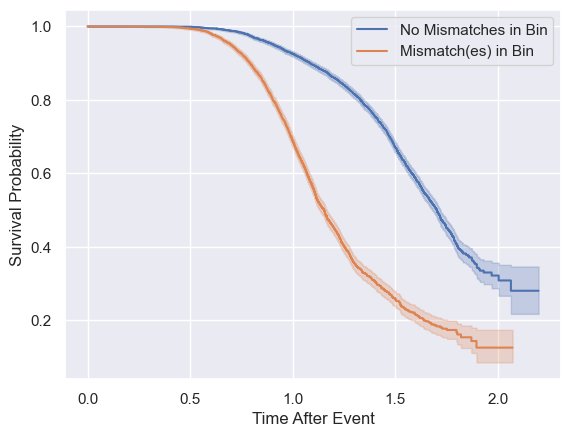

In [21]:
bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features = run_sim_train(training_data)

In [22]:
amino_acid_bin_scores_sorted = sorted(amino_acid_bin_scores.items(), 
                                               key=lambda x:x[1], reverse=True)
amino_acid_bins_sorted = sorted(amino_acid_bins.items(), 
                                         key=lambda x:len(x[1]), reverse=True)
tdf1 = pd.DataFrame(amino_acid_bin_scores_sorted, columns=['Bin #', 'Score'])
tdf2 = pd.DataFrame(amino_acid_bins_sorted, columns=['Bin #', 'Bins'])
tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
tdf3.head(10)

,Bin #,Score,Bins
0,Bin 1,1872.914682,"[P_10, P_2, P_6]"
1,Bin 2,1839.253594,"[P_10, P_7, P_2]"
2,Bin 3,1838.962265,"[P_10, P_4, P_6]"
3,Bin 4,1820.186528,"[P_6, P_8, P_4]"
4,Bin 5,1819.292018,"[P_6, P_8, P_5]"
5,Bin 6,1814.526219,"[P_1, P_10, P_6]"
6,Bin 7,1812.359945,"[P_10, P_5, P_4]"
7,Bin 8,1806.960642,"[P_1, P_6, P_2]"
8,Bin 9,1799.953386,"[P_10, P_6, P_9]"
9,Bin 10,1788.016961,"[P_7, P_1, P_8]"


In [23]:
negative_data = training_data.copy()
negative_data['Censoring'] = list(negative_data['Censoring'].sample(frac=1))
negative_data['Duration'] = list(negative_data['Duration'].sample(frac=1))

Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:27.382042
Top Bin of Features:
['R_19', 'R_23', 'P_4']
---
Number of Instances with No Mismatches in Bin:
2459
Number of Instances with Mismatch(es) in Bin:
7541
---
p-value from Log Rank Test:
0.0004925458004050275


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.14 <0.005     10.99

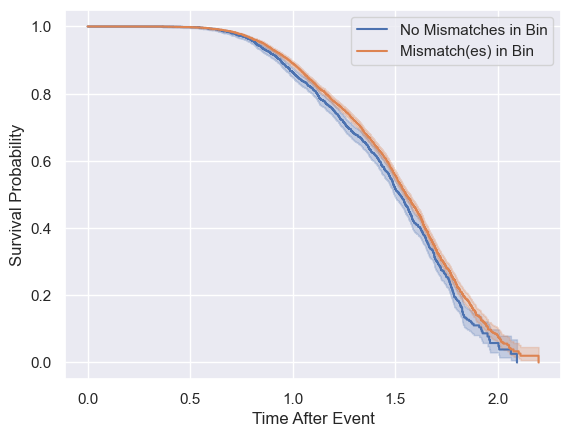

In [24]:
bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features = run_sim_train(negative_data)

In [25]:
amino_acid_bin_scores_sorted = sorted(amino_acid_bin_scores.items(), 
                                               key=lambda x:x[1], reverse=True)
amino_acid_bins_sorted = sorted(amino_acid_bins.items(), 
                                         key=lambda x:len(x[1]), reverse=True)
tdf1 = pd.DataFrame(amino_acid_bin_scores_sorted, columns=['Bin #', 'Score'])
tdf2 = pd.DataFrame(amino_acid_bins_sorted, columns=['Bin #', 'Bins'])
tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
tdf3.head(10)

,Bin #,Score,Bins
0,Bin 1,12.143677,"[R_19, R_23, P_4]"
1,Bin 2,10.644705,"[R_22, P_4, P_2, R_23]"
2,Bin 3,9.867713,"[P_4, R_19]"
3,Bin 4,8.676430,"[R_23, R_5]"
4,Bin 5,7.874482,"[P_4, R_19, R_10]"
5,Bin 6,7.509498,"[R_32, R_30]"
6,Bin 7,7.423360,"[R_36, R_40]"
7,Bin 46,6.761499,"[P_4, R_19, R_8]"
8,Bin 8,6.114285,[R_40]
9,Bin 9,6.047779,"[R_24, R_6]"


In [26]:
def function(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                                no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), 
                                noise_frequency=0,
                                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2), 
                                censoring_frequency=0.5):
    print("mm_frequency_range =", mm_frequency_range, "noise_frequency =", 
          noise_frequency, "censoring_frequency =", censoring_frequency)
    training_data = create_data_simulation_bin(
                                number_of_instances, number_of_features, number_of_features_in_bin,
                                no_fail_proportion, mm_frequency_range, noise_frequency,
                                class0_time_to_event_range, class1_time_to_event_range, censoring_frequency)
    bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features = run_sim_train(training_data)
    amino_acid_bin_scores_sorted = sorted(amino_acid_bin_scores.items(), 
                                               key=lambda x:x[1], reverse=True)
    amino_acid_bins_sorted = sorted(amino_acid_bins.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10))
    return tdf3

mm_frequency_range = (0.01, 0.1) noise_frequency = 0 censoring_frequency = 0.5
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:23.455183
Top Bin of Features:
['R_30', 'R_21', 'R_22', 'R_14', 'R_37', 'R_24', 'R_40']
---
Number of Instances with No Mismatches in Bin:
7365
Number of Instances with Mismatch(es) in Bin:
2635
---
p-value from Log Rank Test:
2.3893920686870314e-06


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          22.25 <0.005     18.67

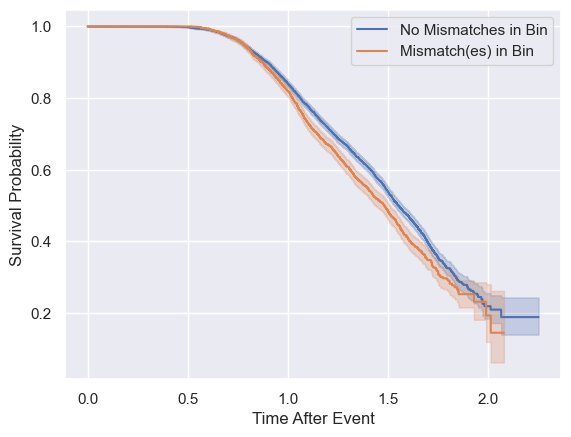

,Bin #,Score,Bins
0,Bin 1,22.253369,"[R_30, R_21, R_22, R_14, R_37, R_24, R_40]"
1,Bin 2,19.154431,"[R_16, R_24, R_22, R_21, R_26, R_40, R_39, R_8..."
2,Bin 3,18.708960,"[R_30, R_40, R_12, R_37, R_8, R_39]"
3,Bin 4,17.476001,"[R_37, R_24, R_40, R_39, R_30, R_2, R_17]"
4,Bin 5,17.470397,"[R_22, R_14, R_40, R_2, R_19, R_39, R_30, R_21..."
5,Bin 6,16.334669,"[R_14, R_16, R_40, R_21, R_24, R_22]"
6,Bin 7,16.289891,"[R_21, R_22, R_27, R_39, R_40]"
7,Bin 8,16.140138,"[R_14, R_37, R_27, R_24, R_40, R_39]"
8,Bin 9,16.068341,"[R_24, R_40, R_22, R_2, R_27, R_21, R_6, R_8, ..."
9,Bin 10,15.680864,"[R_21, R_30, R_14, R_27, R_39, R_40, R_38]"


In [27]:
df1 = function(mm_frequency_range=(0.01, 0.1))
df1 = df1.drop('Bin #', axis=1).head(10)
df1['MM_Range'] = str((0.01, 0.1))

mm_frequency_range = (0.1, 0.2) noise_frequency = 0 censoring_frequency = 0.5
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:26.974504
Top Bin of Features:
['P_9', 'P_4', 'P_6', 'P_2', 'P_3']
---
Number of Instances with No Mismatches in Bin:
7490
Number of Instances with Mismatch(es) in Bin:
2510
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1980.21 <0.005       inf

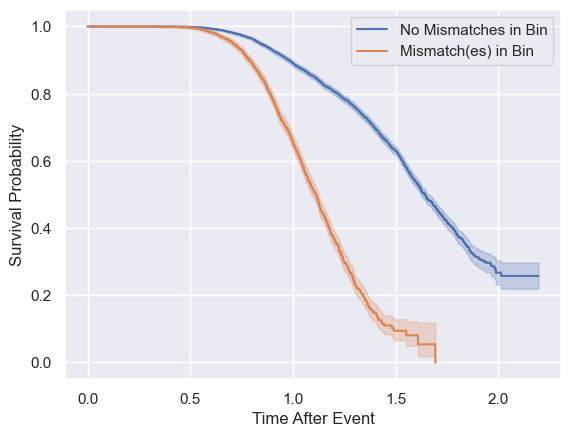

,Bin #,Score,Bins
0,Bin 1,1980.214457,"[P_9, P_4, P_6, P_2, P_3]"
1,Bin 2,1513.356485,"[P_4, P_5, P_6, P_1]"
2,Bin 3,1503.441424,"[P_4, P_3, P_6, P_5]"
3,Bin 4,1493.678367,"[P_4, P_5, P_1, P_9]"
4,Bin 5,1128.845307,"[P_3, P_6, P_2, P_9, P_4, P_1, R_38]"
5,Bin 6,724.037309,"[P_4, P_1, P_10, P_3, R_24, P_9]"
6,Bin 7,671.004474,"[P_2, P_4, P_9, P_3, R_15, P_10]"
7,Bin 8,656.860159,"[P_5, P_3, P_8, P_10, P_7, R_30]"
8,Bin 9,588.004809,"[P_4, P_6, P_3, P_1, R_39]"
9,Bin 10,563.752195,"[P_1, P_5, P_3, P_4, R_20]"


mm_frequency_range = (0.2, 0.3) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:25.498042
Top Bin of Features:
['P_10', 'P_3', 'P_1', 'P_6', 'P_7']
---
Number of Instances with No Mismatches in Bin:
6100
Number of Instances with Mismatch(es) in Bin:
3900
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3429.93 <0.005       inf

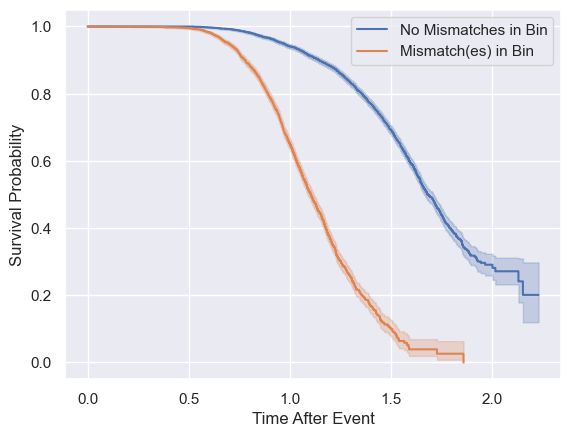

,Bin #,Score,Bins
0,Bin 1,3429.927555,"[P_10, P_3, P_1, P_6, P_7]"
1,Bin 2,2986.654473,"[P_9, P_10, P_1, P_7]"
2,Bin 3,2890.970060,"[P_7, P_5, P_1, P_6]"
3,Bin 4,2881.657186,"[P_9, P_7, P_2, P_1]"
4,Bin 5,2874.264092,"[P_6, P_2, P_4, P_5]"
5,Bin 6,2860.044467,"[P_10, P_9, P_6, P_1]"
6,Bin 7,2855.333224,"[P_3, P_1, P_6, P_4]"
7,Bin 8,2810.397998,"[P_3, P_6, P_7, P_2]"
8,Bin 9,2780.622815,"[P_4, P_5, P_6, P_8]"
9,Bin 10,2676.940647,"[P_9, P_8, P_6, P_5]"


mm_frequency_range = (0.3, 0.4) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:23.858804
Top Bin of Features:
['P_9', 'P_6', 'P_3', 'P_5', 'P_1']
---
Number of Instances with No Mismatches in Bin:
5432
Number of Instances with Mismatch(es) in Bin:
4568
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4003.72 <0.005       inf

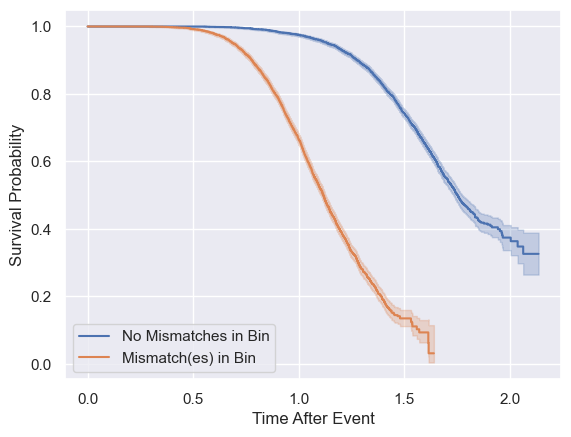

,Bin #,Score,Bins
0,Bin 1,4003.719158,"[P_9, P_6, P_3, P_5, P_1]"
1,Bin 2,4003.518815,"[P_1, P_8, P_4, P_6, P_9]"
2,Bin 3,3662.057908,"[P_5, P_6, P_4, P_2]"
3,Bin 4,3583.266205,"[P_9, P_5, P_7, P_6]"
4,Bin 5,3561.975474,"[P_3, P_6, P_5, P_8]"
5,Bin 6,3457.969023,"[P_9, P_5, P_1, P_7]"
6,Bin 7,3454.549827,"[P_5, P_8, P_9, P_1]"
7,Bin 8,3452.347356,"[P_7, P_4, P_10, P_3]"
8,Bin 9,3082.602280,"[P_6, P_4, P_2]"
9,Bin 10,3019.042142,"[P_4, P_6, P_5]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:24.325014
Top Bin of Features:
['P_1', 'P_6', 'P_5', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5367
Number of Instances with Mismatch(es) in Bin:
4633
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4380.35 <0.005       inf

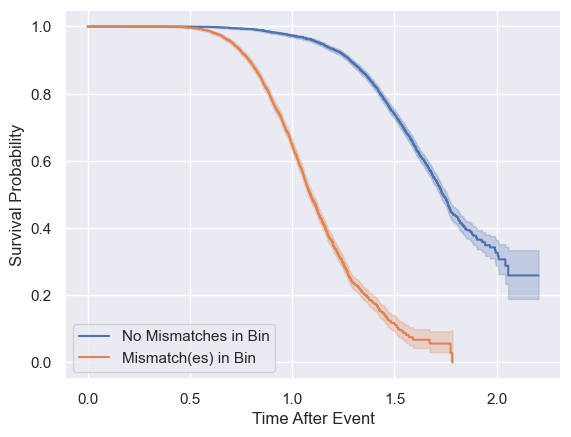

,Bin #,Score,Bins
0,Bin 1,4380.345735,"[P_1, P_6, P_5, P_10]"
1,Bin 2,3958.055385,"[P_10, P_9, P_5]"
2,Bin 3,3948.399768,"[P_5, P_3, P_9]"
3,Bin 4,3895.417181,"[P_5, P_4, P_9]"
4,Bin 5,3863.674463,"[P_3, P_1, P_5]"
5,Bin 6,3827.725315,"[P_9, P_7, P_6]"
6,Bin 7,3819.353706,"[P_1, P_10, P_9]"
7,Bin 8,3807.926702,"[P_1, P_5, P_9]"
8,Bin 9,3800.475566,"[P_1, P_2, P_5]"
9,Bin 10,3797.669728,"[P_5, P_9, P_7]"


mm_frequency_range = (0.5, 0.6) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:24.624855
Top Bin of Features:
['P_2', 'P_1', 'P_10', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5096
Number of Instances with Mismatch(es) in Bin:
4904
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4978.87 <0.005       inf

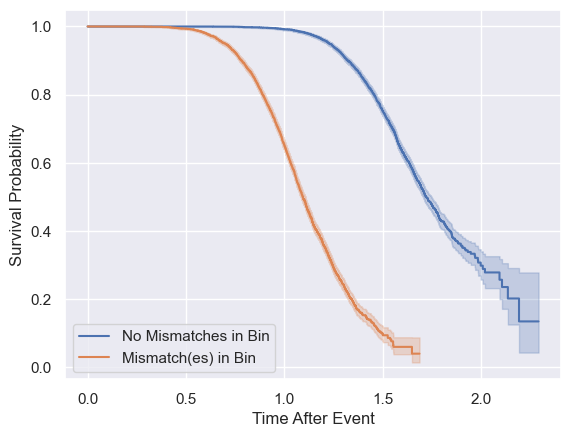

,Bin #,Score,Bins
0,Bin 1,4978.871917,"[P_2, P_1, P_10, P_9]"
1,Bin 2,4932.092351,"[P_2, P_1, P_8, P_3]"
2,Bin 3,4915.344207,"[P_9, P_6, P_8, P_3]"
3,Bin 4,4582.584836,"[P_4, P_3, P_1]"
4,Bin 5,4555.185861,"[P_4, P_1, P_5]"
5,Bin 6,4531.800097,"[P_1, P_9, P_3]"
6,Bin 7,4530.987627,"[P_2, P_9, P_7]"
7,Bin 8,4512.714293,"[P_3, P_7, P_4]"
8,Bin 9,4503.802968,"[P_7, P_8, P_2]"
9,Bin 10,4500.373869,"[P_6, P_9, P_5]"


mm_frequency_range = (0.6, 0.7) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:18.324133
Top Bin of Features:
['P_4', 'P_10', 'P_8', 'P_3']
---
Number of Instances with No Mismatches in Bin:
5018
Number of Instances with Mismatch(es) in Bin:
4982
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4878.13 <0.005       inf

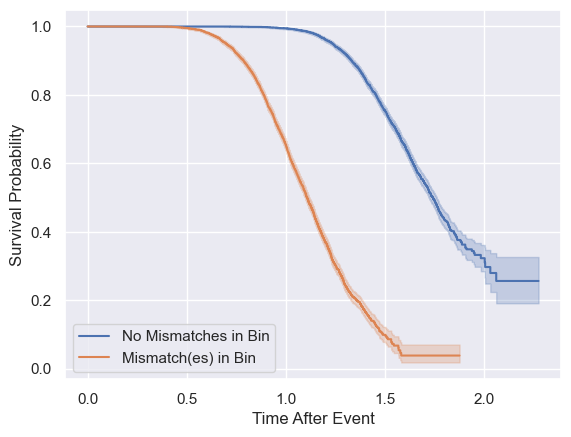

,Bin #,Score,Bins
0,Bin 1,4878.134404,"[P_4, P_10, P_8, P_3]"
1,Bin 2,4875.256955,"[P_2, P_3, P_5, P_9]"
2,Bin 3,4699.730766,"[P_9, P_2, P_5]"
3,Bin 4,4695.459784,"[P_10, P_3, P_8]"
4,Bin 5,4691.607987,"[P_2, P_9, P_6]"
5,Bin 6,4688.716623,"[P_5, P_3, P_9]"
6,Bin 7,4687.746477,"[P_9, P_1, P_2]"
7,Bin 8,4681.630692,"[P_6, P_1, P_5]"
8,Bin 9,4680.558722,"[P_5, P_8, P_2]"
9,Bin 10,4666.069961,"[P_8, P_3, P_4]"


mm_frequency_range = (0.7, 0.8) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:13.082098
Top Bin of Features:
['P_4', 'P_10', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5041
Number of Instances with Mismatch(es) in Bin:
4959
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4605.65 <0.005       inf

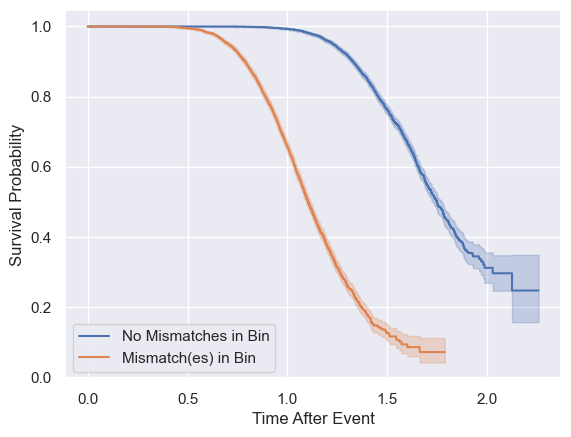

,Bin #,Score,Bins
0,Bin 1,4605.646296,"[P_4, P_10, P_8]"
1,Bin 2,4603.019905,"[P_5, P_1, P_7]"
2,Bin 3,4565.922126,"[P_6, P_2, P_4]"
3,Bin 4,4550.497909,"[P_2, P_6, P_7]"
4,Bin 5,4329.557239,"[P_2, P_8]"
5,Bin 6,4279.840446,"[P_3, P_9]"
6,Bin 7,4275.695795,"[P_4, P_8]"
7,Bin 8,4255.449387,"[P_3, P_2]"
8,Bin 9,4253.932951,"[P_5, P_2]"
9,Bin 10,4237.110972,"[P_3, P_8]"


mm_frequency_range = (0.8, 0.9) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:00:47.989929
Top Bin of Features:
['P_3', 'P_6', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5000
Number of Instances with Mismatch(es) in Bin:
5000
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4955.00 <0.005       inf

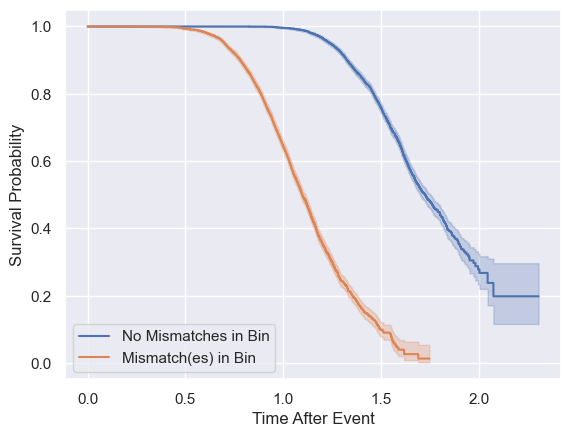

,Bin #,Score,Bins
0,Bin 1,4954.998657,"[P_3, P_6, P_9]"
1,Bin 2,4954.998657,"[P_5, P_9, P_7]"
2,Bin 3,4954.998657,"[P_8, P_5, P_10]"
3,Bin 4,4954.998657,"[P_3, P_6, P_8]"
4,Bin 5,4954.998657,"[P_2, P_7, P_6]"
5,Bin 6,4954.998657,"[P_9, P_6, P_10]"
6,Bin 7,4954.998657,"[P_2, P_7, P_3]"
7,Bin 8,4954.998657,"[P_6, P_4, P_2]"
8,Bin 9,4954.998657,"[P_5, P_9, P_1]"
9,Bin 10,4954.998657,"[P_10, P_5, P_9]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3810267475.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


In [28]:
for i in range(1, 9):
    tdf = function(mm_frequency_range=(i/10, (i+1)/10))
    tdf = tdf.drop(['Bin #'], axis=1).head(10)
    tdf['MM_Range'] = str((i/10, (i+1)/10))
    df1 = df1.append(tdf)

mm_frequency_range = (0.9, 0.99) noise_frequency = 0 censoring_frequency = 0.5
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:00:50.494091
Top Bin of Features:
['P_5', 'P_7']
---
Number of Instances with No Mismatches in Bin:
5000
Number of Instances with Mismatch(es) in Bin:
5000
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4940.61 <0.005       inf

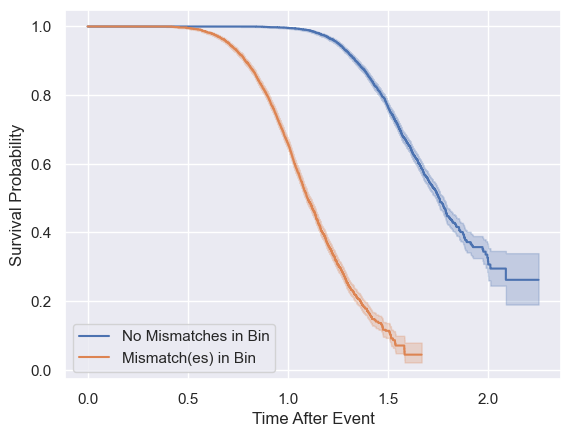

,Bin #,Score,Bins
0,Bin 1,4940.605357,"[P_5, P_7]"
1,Bin 2,4940.605357,"[P_10, P_8]"
2,Bin 3,4940.605357,"[P_7, P_8]"
3,Bin 4,4940.605357,"[P_4, P_5]"
4,Bin 5,4940.605357,"[P_2, P_5]"
5,Bin 6,4940.605357,"[P_10, P_2]"
6,Bin 7,4940.605357,"[P_6, P_8]"
7,Bin 8,4940.605357,"[P_3, P_8]"
8,Bin 9,4940.605357,"[P_9, P_3]"
9,Bin 10,4940.605357,"[P_10, P_3]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/1461565073.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


In [29]:
tdf = function(mm_frequency_range=(0.9, 0.99))
tdf = tdf.drop(['Bin #'], axis=1).head(10)
tdf['MM_Range'] = str((i/10, (i+1)/10))
df1 = df1.append(tdf)

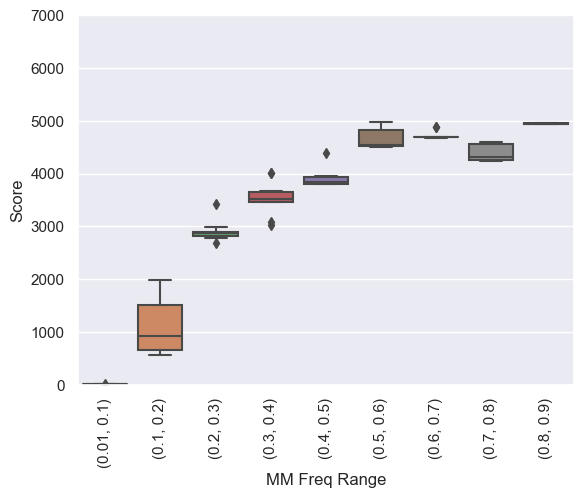

In [30]:
sns.boxplot(y=df1['Score'], x=df1['MM_Range'])
plt.xticks(rotation=90)
plt.xlabel('MM Freq Range')
plt.ylim(bottom=0, top=7000)
plt.show()

mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.1
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:24.157650
Top Bin of Features:
['P_6', 'P_4', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5822
Number of Instances with Mismatch(es) in Bin:
4178
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3842.81 <0.005       inf

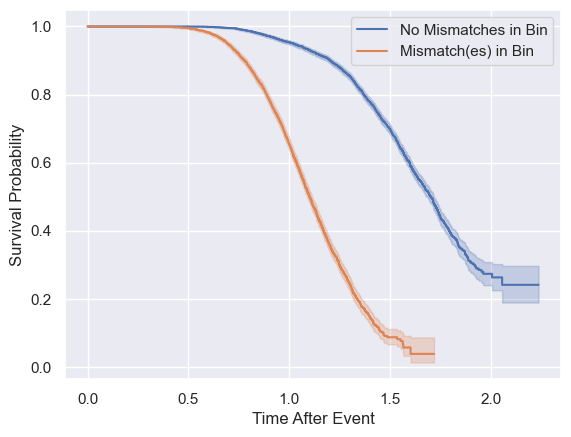

,Bin #,Score,Bins
0,Bin 1,3842.813880,"[P_6, P_4, P_10]"
1,Bin 2,3836.268102,"[P_7, P_8, P_6]"
2,Bin 3,3826.591684,"[P_7, P_9, P_5]"
3,Bin 4,3819.655896,"[P_6, P_9, P_5]"
4,Bin 5,3811.626529,"[P_6, P_9, P_7]"
5,Bin 6,3800.221267,"[P_2, P_10, P_4]"
6,Bin 7,3798.922381,"[P_9, P_5, P_1]"
7,Bin 8,3797.937829,"[P_7, P_9, P_4]"
8,Bin 9,3781.775680,"[P_3, P_1, P_9]"
9,Bin 10,3780.365473,"[P_10, P_7, P_3]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.2


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:24.206502
Top Bin of Features:
['P_8', 'P_6', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5832
Number of Instances with Mismatch(es) in Bin:
4168
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3679.40 <0.005       inf

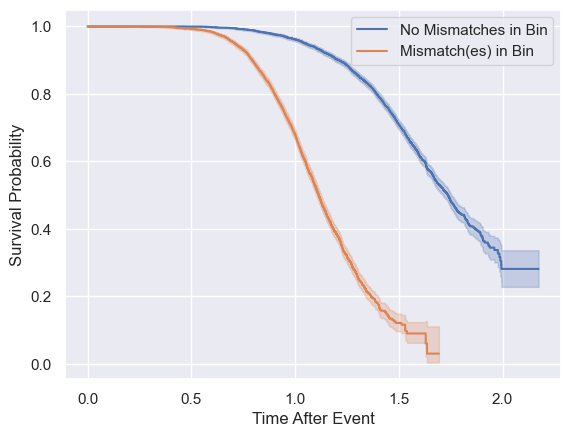

,Bin #,Score,Bins
0,Bin 1,3679.400634,"[P_8, P_6, P_5]"
1,Bin 2,3625.525974,"[P_4, P_6, P_2]"
2,Bin 3,3621.785490,"[P_6, P_2, P_10]"
3,Bin 4,3612.726914,"[P_2, P_6, P_8]"
4,Bin 5,3590.202741,"[P_7, P_8, P_2]"
5,Bin 6,3565.712025,"[P_2, P_4, P_1]"
6,Bin 7,3565.099952,"[P_2, P_1, P_10]"
7,Bin 8,3542.521683,"[P_7, P_9, P_2]"
8,Bin 9,3540.945499,"[P_2, P_8, P_1]"
9,Bin 10,3530.668795,"[P_5, P_1, P_4]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.3


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:25.816464
Top Bin of Features:
['P_5', 'P_4', 'P_10', 'P_2']
---
Number of Instances with No Mismatches in Bin:
5388
Number of Instances with Mismatch(es) in Bin:
4612
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4158.26 <0.005       inf

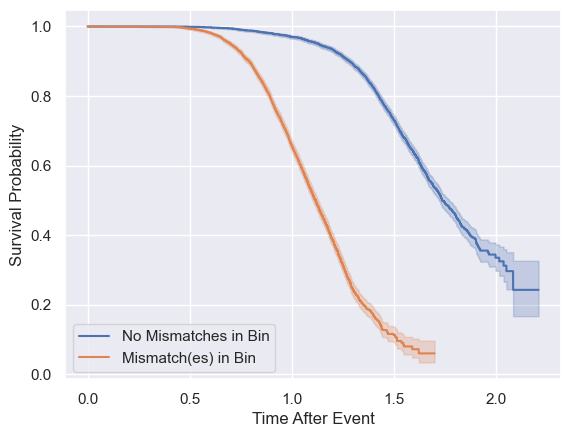

,Bin #,Score,Bins
0,Bin 1,4158.258850,"[P_5, P_4, P_10, P_2]"
1,Bin 2,3905.573372,"[P_9, P_3, P_10]"
2,Bin 3,3865.397137,"[P_1, P_10, P_8]"
3,Bin 4,3833.530392,"[P_1, P_8, P_6]"
4,Bin 5,3816.162193,"[P_10, P_4, P_1]"
5,Bin 6,3761.617577,"[P_2, P_1, P_9]"
6,Bin 7,3759.760112,"[P_9, P_2, P_3]"
7,Bin 8,3755.483833,"[P_6, P_1, P_10]"
8,Bin 9,3741.461377,"[P_3, P_5, P_8]"
9,Bin 10,3738.816920,"[P_10, P_1, P_9]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.4


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:23.372819
Top Bin of Features:
['P_10', 'P_3', 'P_4', 'P_2']
---
Number of Instances with No Mismatches in Bin:
5373
Number of Instances with Mismatch(es) in Bin:
4627
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4316.68 <0.005       inf

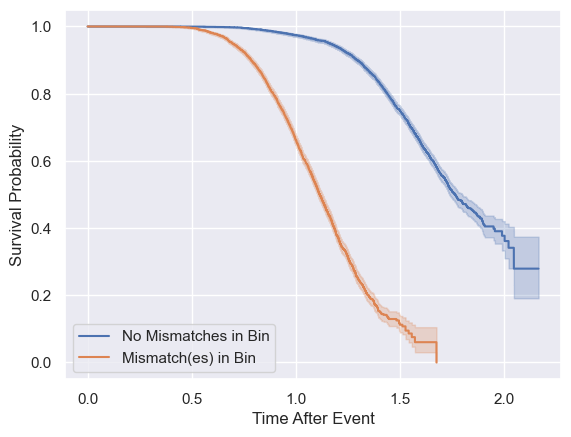

,Bin #,Score,Bins
0,Bin 1,4316.679251,"[P_10, P_3, P_4, P_2]"
1,Bin 2,4300.648208,"[P_2, P_7, P_3, P_10]"
2,Bin 3,3871.601635,"[P_4, P_2, P_5]"
3,Bin 4,3867.135192,"[P_4, P_2, P_6]"
4,Bin 5,3850.251341,"[P_2, P_8, P_4]"
5,Bin 6,3824.485489,"[P_7, P_2, P_4]"
6,Bin 7,3821.685964,"[P_7, P_1, P_2]"
7,Bin 8,3780.463297,"[P_5, P_2, P_7]"
8,Bin 9,3773.274393,"[P_7, P_2, P_6]"
9,Bin 10,3753.811952,"[P_8, P_4, P_7]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:24.319044
Top Bin of Features:
['P_5', 'P_9', 'P_1', 'P_4', 'P_2']
---
Number of Instances with No Mismatches in Bin:
5122
Number of Instances with Mismatch(es) in Bin:
4878
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4581.24 <0.005       inf

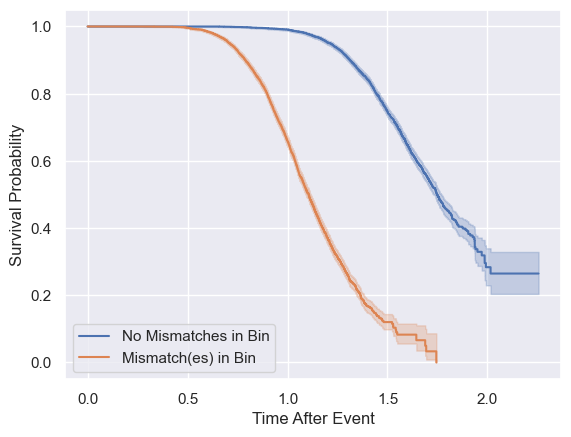

,Bin #,Score,Bins
0,Bin 1,4581.244912,"[P_5, P_9, P_1, P_4, P_2]"
1,Bin 2,4554.764368,"[P_10, P_3, P_6, P_9, P_7]"
2,Bin 3,4341.593178,"[P_3, P_6, P_9, P_7]"
3,Bin 4,4259.670584,"[P_4, P_10, P_6, P_8]"
4,Bin 5,4253.535263,"[P_4, P_7, P_1, P_2]"
5,Bin 6,4221.881804,"[P_10, P_1, P_8, P_6]"
6,Bin 7,4209.234283,"[P_7, P_2, P_6, P_10]"
7,Bin 8,4190.393652,"[P_7, P_1, P_8, P_9]"
8,Bin 9,4159.239921,"[P_1, P_8, P_4, P_6]"
9,Bin 10,4157.886738,"[P_9, P_4, P_10, P_1]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.6


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:20.491674
Top Bin of Features:
['P_8', 'P_2', 'P_6', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5355
Number of Instances with Mismatch(es) in Bin:
4645
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4508.81 <0.005       inf

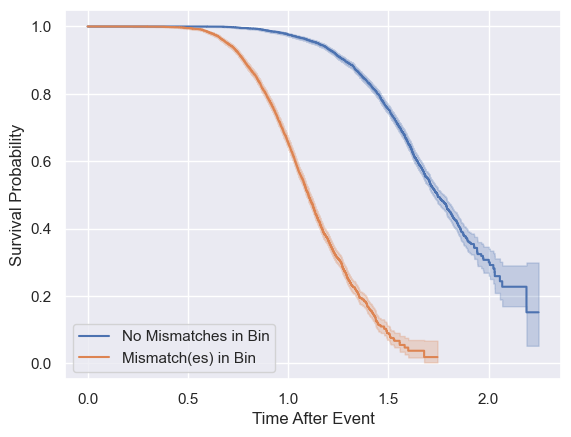

,Bin #,Score,Bins
0,Bin 1,4508.813717,"[P_8, P_2, P_6, P_5]"
1,Bin 2,4350.737969,"[P_6, P_2, P_7, P_9]"
2,Bin 3,3930.320027,"[P_7, P_3, P_1]"
3,Bin 4,3911.981285,"[P_6, P_1, P_5]"
4,Bin 5,3864.687852,"[P_8, P_6, P_7]"
5,Bin 6,3837.591846,"[P_8, P_10, P_7]"
6,Bin 7,3830.116630,"[P_2, P_6, P_8]"
7,Bin 8,3829.041114,"[P_7, P_4, P_1]"
8,Bin 9,3807.475976,"[P_7, P_3, P_4]"
9,Bin 10,3797.324738,"[P_8, P_6, P_9]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.7


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:20.523456
Top Bin of Features:
['P_7', 'P_9', 'P_10', 'P_2']
---
Number of Instances with No Mismatches in Bin:
5321
Number of Instances with Mismatch(es) in Bin:
4679
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4469.81 <0.005       inf

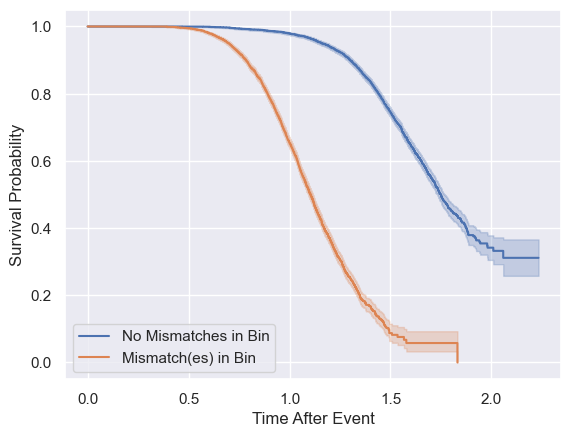

,Bin #,Score,Bins
0,Bin 1,4469.809749,"[P_7, P_9, P_10, P_2]"
1,Bin 2,4407.991696,"[P_8, P_7, P_2, P_9]"
2,Bin 3,4396.277520,"[P_1, P_7, P_6, P_4]"
3,Bin 4,4371.570789,"[P_5, P_6, P_1, P_8]"
4,Bin 5,4362.579162,"[P_4, P_1, P_9, P_8]"
5,Bin 6,4324.259388,"[P_1, P_8, P_2, P_9]"
6,Bin 7,4295.380518,"[P_9, P_10, P_2, P_1]"
7,Bin 8,3799.418131,"[P_7, P_2, P_9]"
8,Bin 9,3798.215484,"[P_10, P_5, P_1]"
9,Bin 10,3794.286690,"[P_7, P_1, P_2]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.8


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:22.607104
Top Bin of Features:
['P_7', 'P_5', 'P_2', 'P_3']
---
Number of Instances with No Mismatches in Bin:
5363
Number of Instances with Mismatch(es) in Bin:
4637
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4107.66 <0.005       inf

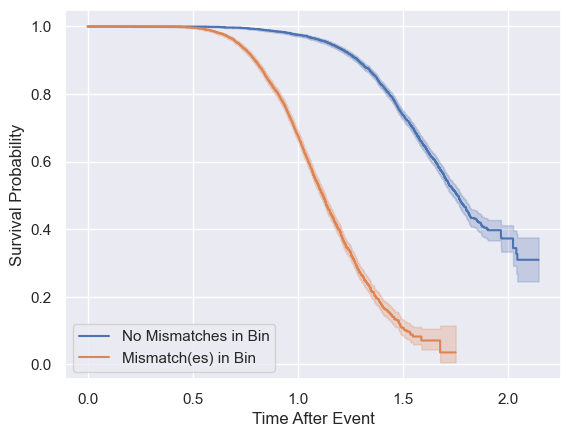

,Bin #,Score,Bins
0,Bin 1,4107.662610,"[P_7, P_5, P_2, P_3]"
1,Bin 2,3743.109936,"[P_8, P_6, P_7]"
2,Bin 3,3688.102143,"[P_2, P_6, P_8]"
3,Bin 4,3656.937521,"[P_6, P_8, P_9]"
4,Bin 41,3653.661131,"[P_3, P_2, P_4]"
5,Bin 47,3641.718796,"[P_4, P_6, P_7]"
6,Bin 5,3638.280341,"[P_5, P_6, P_10]"
7,Bin 6,3619.073661,"[P_6, P_4, P_8]"
8,Bin 7,3607.949183,"[P_2, P_4, P_6]"
9,Bin 8,3602.439440,"[P_3, P_9, P_8]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3882707139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


In [31]:
df1 = pd.DataFrame()
for i in range(1, 9):
    tdf = function(censoring_frequency=i/10)
    tdf = tdf.drop(['Bin #'], axis=1).head(10)
    tdf['Cen_Freq'] = i/10
    df1 = df1.append(tdf)

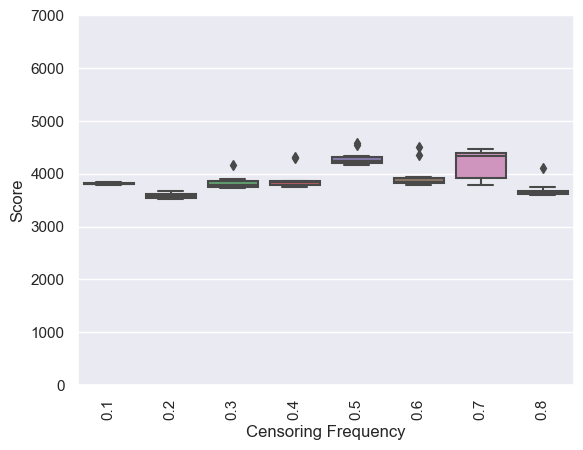

In [32]:
sns.boxplot(y=df1['Score'], x=df1['Cen_Freq'])
plt.xticks(rotation=90)
plt.xlabel('Censoring Frequency')
plt.ylim(bottom=0, top=7000)
plt.show()

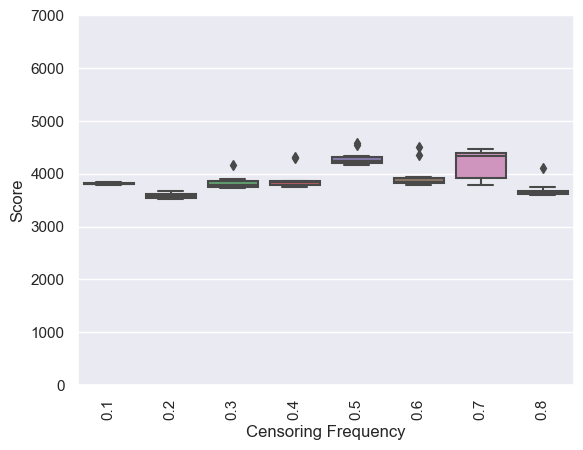

In [33]:
sns.boxplot(y=df1['Score'], x=df1['Cen_Freq'])
plt.xticks(rotation=90)
plt.xlabel('Censoring Frequency')
plt.ylim(bottom=0, top=7000)
plt.show()

mm_frequency_range = (0.4, 0.5) noise_frequency = 0.0 censoring_frequency = 0.5
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:22.563182
Top Bin of Features:
['P_2', 'P_1', 'P_9', 'P_4', 'P_3']
---
Number of Instances with No Mismatches in Bin:
5118
Number of Instances with Mismatch(es) in Bin:
4882
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4785.83 <0.005       inf

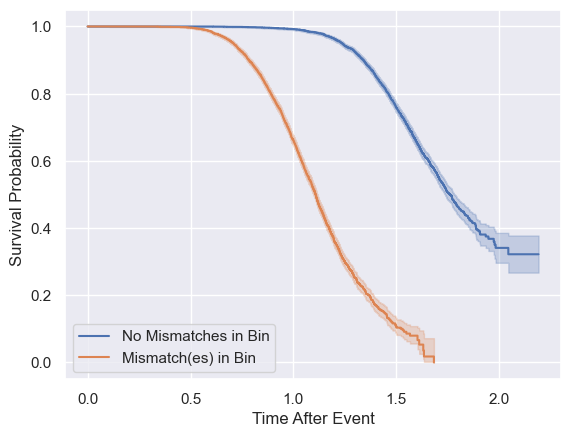

,Bin #,Score,Bins
0,Bin 1,4785.826131,"[P_2, P_1, P_9, P_4, P_3]"
1,Bin 2,4479.754527,"[P_4, P_1, P_8, P_2]"
2,Bin 3,4393.292062,"[P_10, P_3, P_1, P_4]"
3,Bin 4,4374.535492,"[P_8, P_4, P_7, P_2]"
4,Bin 5,3937.035010,"[P_9, P_2, P_1]"
5,Bin 6,3916.394213,"[P_2, P_9, P_4]"
6,Bin 7,3902.567697,"[P_6, P_9, P_1]"
7,Bin 8,3860.624485,"[P_2, P_4, P_3]"
8,Bin 9,3823.795586,"[P_2, P_1, P_8]"
9,Bin 10,3812.269136,"[P_9, P_4, P_3]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0.1 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:23.744588
Top Bin of Features:
['P_8', 'P_1', 'P_4', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5347
Number of Instances with Mismatch(es) in Bin:
4653
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2416.65 <0.005       inf

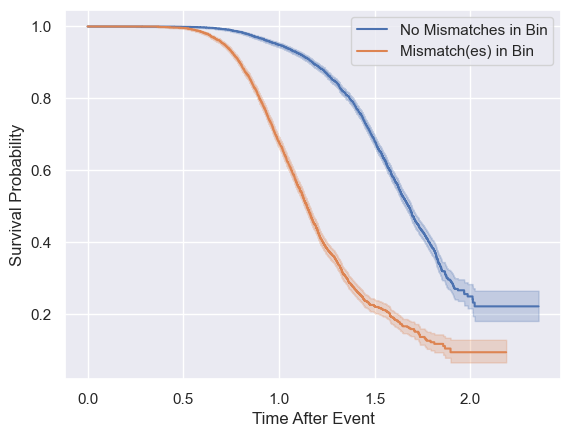

,Bin #,Score,Bins
0,Bin 1,2416.645078,"[P_8, P_1, P_4, P_9]"
1,Bin 2,2163.171810,"[P_8, P_10, P_9]"
2,Bin 3,2135.136134,"[P_9, P_1, P_8]"
3,Bin 4,2126.606909,"[P_2, P_1, P_9]"
4,Bin 5,2120.433670,"[P_1, P_8, P_10]"
5,Bin 6,2116.064022,"[P_2, P_9, P_8]"
6,Bin 7,2081.912238,"[P_6, P_8, P_10]"
7,Bin 8,2078.500655,"[P_6, P_9, P_2]"
8,Bin 9,2071.935930,"[P_4, P_8, P_10]"
9,Bin 10,2049.177144,"[P_1, P_4, P_8]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0.2 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:27.544180
Top Bin of Features:
['P_5', 'P_4', 'P_1', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5365
Number of Instances with Mismatch(es) in Bin:
4635
---
p-value from Log Rank Test:
1.026545000581995e-222


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1014.92 <0.005    737.43

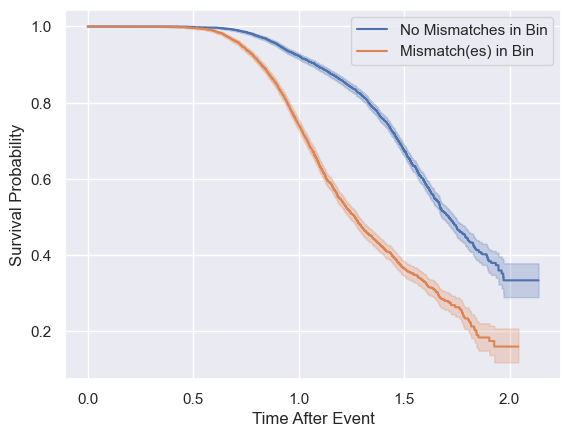

,Bin #,Score,Bins
0,Bin 1,1014.919271,"[P_5, P_4, P_1, P_6]"
1,Bin 2,956.963461,"[P_10, P_8, P_4, P_5]"
2,Bin 3,931.518235,"[P_9, P_10, P_7]"
3,Bin 4,884.077378,"[P_1, P_7, P_9]"
4,Bin 5,873.430626,"[P_4, P_8, P_7]"
5,Bin 6,873.294596,"[P_4, P_7, P_1]"
6,Bin 7,868.376958,"[P_5, P_4, P_9]"
7,Bin 8,856.719399,"[P_7, P_2, P_4]"
8,Bin 9,843.226985,"[P_4, P_1, P_5]"
9,Bin 10,825.189545,"[P_2, P_5, P_9]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0.3 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:27.778407
Top Bin of Features:
['P_7', 'P_10', 'P_3', 'P_4']
---
Number of Instances with No Mismatches in Bin:
5338
Number of Instances with Mismatch(es) in Bin:
4662
---
p-value from Log Rank Test:
1.2788527665661175e-90


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         407.51 <0.005    298.62

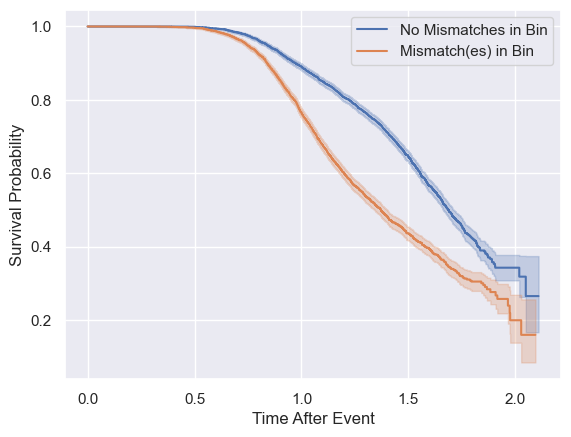

,Bin #,Score,Bins
0,Bin 1,407.506871,"[P_7, P_10, P_3, P_4]"
1,Bin 2,399.336565,"[P_10, P_8, P_2]"
2,Bin 3,385.415921,"[P_1, P_10, P_5]"
3,Bin 4,377.209491,"[P_10, P_6, P_8]"
4,Bin 5,376.057383,"[P_5, P_10, P_7]"
5,Bin 6,373.704501,"[P_6, P_2, P_3, P_5]"
6,Bin 7,372.483379,"[P_10, P_4, P_8]"
7,Bin 8,366.454004,"[P_7, P_6, P_4]"
8,Bin 9,364.264201,"[P_5, P_10, P_6]"
9,Bin 10,356.462394,"[P_10, P_6, P_7]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0.4 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:26.458730
Top Bin of Features:
['P_9', 'P_7', 'P_4', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5345
Number of Instances with Mismatch(es) in Bin:
4655
---
p-value from Log Rank Test:
3.618799464047855e-23


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          98.29 <0.005     74.55

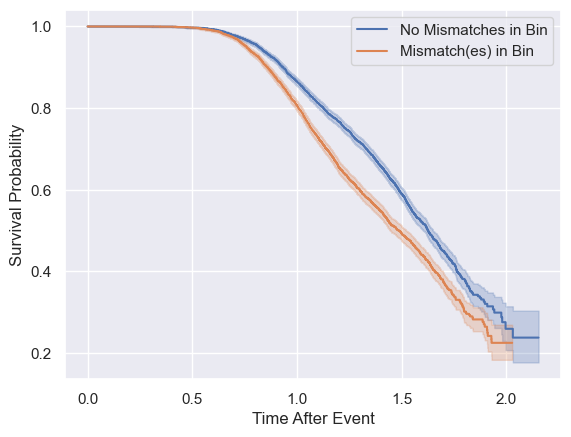

,Bin #,Score,Bins
0,Bin 1,98.287297,"[P_9, P_7, P_4, P_8]"
1,Bin 2,97.666306,"[P_9, P_5, P_8, P_3]"
2,Bin 3,95.222251,"[P_9, P_7, P_3, P_4]"
3,Bin 4,93.029969,"[P_9, P_2, P_7]"
4,Bin 5,88.802181,"[P_7, P_3, P_8]"
5,Bin 6,87.735356,"[P_8, P_7, P_9]"
6,Bin 7,83.774841,"[P_9, P_8, P_10]"
7,Bin 8,82.743745,"[P_8, P_7, P_1]"
8,Bin 9,81.929713,"[P_8, P_3, P_1, P_10]"
9,Bin 10,81.650546,"[P_8, P_1, P_5, P_10]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0.5 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:29.971117
Top Bin of Features:
['R_19', 'R_23']
---
Number of Instances with No Mismatches in Bin:
3111
Number of Instances with Mismatch(es) in Bin:
6889
---
p-value from Log Rank Test:
0.004097690377696309


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.24 <0.005      7.93

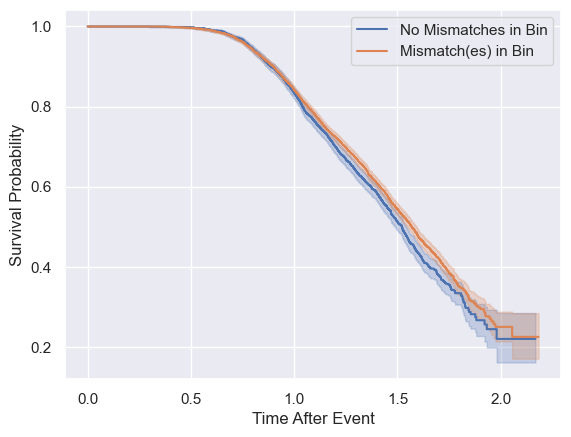

,Bin #,Score,Bins
0,Bin 1,8.240010,"[R_19, R_23]"
1,Bin 2,7.816299,"[R_11, R_19]"
2,Bin 3,7.690901,"[R_11, P_8, R_24, P_5]"
3,Bin 4,6.666003,"[R_11, P_8]"
4,Bin 5,6.633868,"[R_24, P_8, R_40]"
5,Bin 6,6.333750,"[P_10, R_20, R_24]"
6,Bin 7,6.103335,"[R_17, P_8]"
7,Bin 8,6.064754,"[P_8, R_19]"
8,Bin 9,5.304707,"[R_19, R_20]"
9,Bin 10,5.227689,"[R_12, R_24]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2649357394.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


In [34]:
df1 = pd.DataFrame()
for i in range(6):
    tdf = function(noise_frequency=i/10)
    tdf = tdf.drop(['Bin #'], axis=1).head(10)
    tdf['Noise_Freq'] = i/10
    df1 = df1.append(tdf)

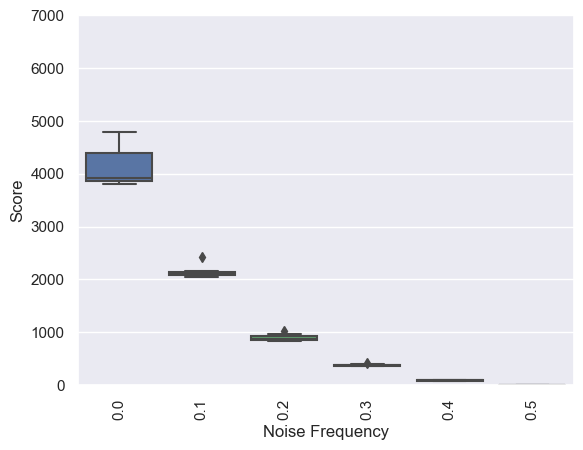

In [35]:
sns.boxplot(y=df1['Score'], x=df1['Noise_Freq'])
plt.xticks(rotation=90)
plt.xlabel('Noise Frequency')
plt.ylim(bottom=0, top=7000)
plt.show()

mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5
Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:25.305031
Top Bin of Features:
['P_9', 'P_2', 'P_1', 'P_8', 'P_6', 'P_4', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5000
Number of Instances with Mismatch(es) in Bin:
5000
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4793.32 <0.005       inf

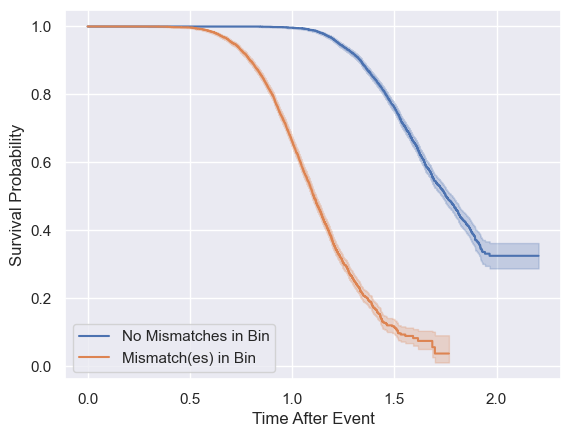

,Bin #,Score,Bins
0,Bin 44,4793.316956,"[P_9, P_2, P_1, P_8, P_6, P_4, P_5]"
1,Bin 1,4774.915829,"[P_2, P_1, P_3, P_5, P_10, P_7]"
2,Bin 2,4769.073497,"[P_3, P_8, P_2, P_10, P_7, P_4]"
3,Bin 3,4751.386426,"[P_4, P_2, P_10, P_8, P_1, P_9]"
4,Bin 4,4746.128971,"[P_9, P_7, P_4, P_3, P_5, P_1]"
5,Bin 5,4745.190502,"[P_10, P_2, P_8, P_5, P_9, P_7]"
6,Bin 6,4674.423638,"[P_3, P_8, P_2, P_7, P_4]"
7,Bin 7,4642.812329,"[P_2, P_10, P_1, P_6, P_5]"
8,Bin 8,4633.175640,"[P_1, P_5, P_9, P_4, P_10]"
9,Bin 9,4630.240115,"[P_9, P_5, P_1, P_8, P_7]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:27.517624
Top Bin of Features:
['P_3', 'P_7', 'P_4', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5329
Number of Instances with Mismatch(es) in Bin:
4671
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4602.38 <0.005       inf

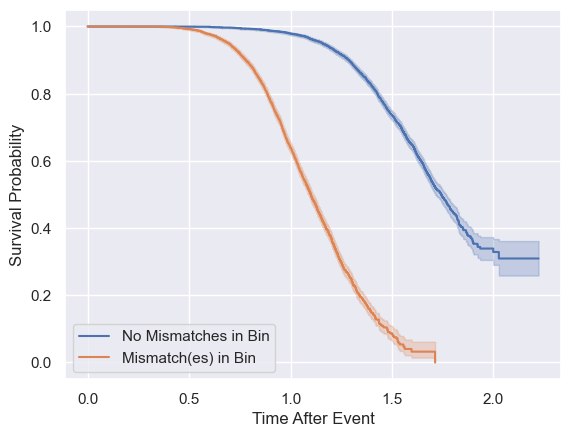

,Bin #,Score,Bins
0,Bin 1,4602.380740,"[P_3, P_7, P_4, P_8]"
1,Bin 2,4516.697059,"[P_1, P_2, P_9, P_7]"
2,Bin 3,4477.078140,"[P_2, P_1, P_9, P_4]"
3,Bin 41,4449.128507,"[P_7, P_8, P_1, P_5]"
4,Bin 4,3984.890148,"[P_4, P_8, P_1]"
5,Bin 5,3947.366610,"[P_4, P_7, P_8]"
6,Bin 6,3919.580574,"[P_7, P_8, P_5]"
7,Bin 7,3897.459635,"[P_7, P_8, P_1]"
8,Bin 8,3845.559177,"[P_1, P_7, P_3]"
9,Bin 9,3841.510097,"[P_3, P_4, P_8]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:25.463652
Top Bin of Features:
['P_6', 'P_9', 'P_8', 'P_2']
---
Number of Instances with No Mismatches in Bin:
5354
Number of Instances with Mismatch(es) in Bin:
4646
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4425.74 <0.005       inf

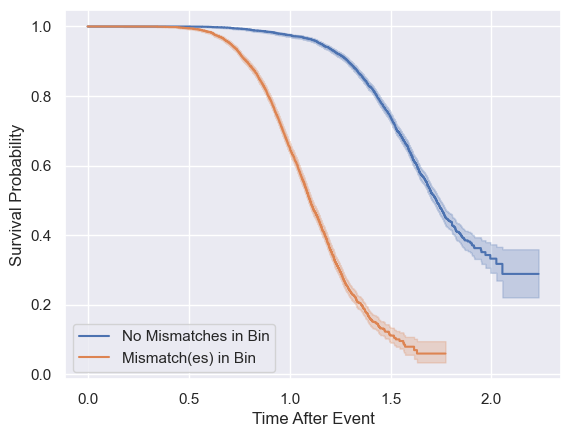

,Bin #,Score,Bins
0,Bin 1,4425.740639,"[P_6, P_9, P_8, P_2]"
1,Bin 2,4386.068420,"[P_8, P_5, P_3, P_9]"
2,Bin 3,4292.380356,"[P_5, P_6, P_8, P_10]"
3,Bin 4,3898.021618,"[P_2, P_8, P_7]"
4,Bin 5,3871.311696,"[P_2, P_9, P_8]"
5,Bin 6,3834.360734,"[P_10, P_9, P_2]"
6,Bin 7,3790.861621,"[P_5, P_3, P_8]"
7,Bin 8,3786.723869,"[P_9, P_7, P_8]"
8,Bin 9,3786.190896,"[P_8, P_6, P_7]"
9,Bin 10,3779.585728,"[P_1, P_9, P_7]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:18.776722
Top Bin of Features:
['P_4', 'P_1', 'P_7', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5356
Number of Instances with Mismatch(es) in Bin:
4644
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4267.56 <0.005       inf

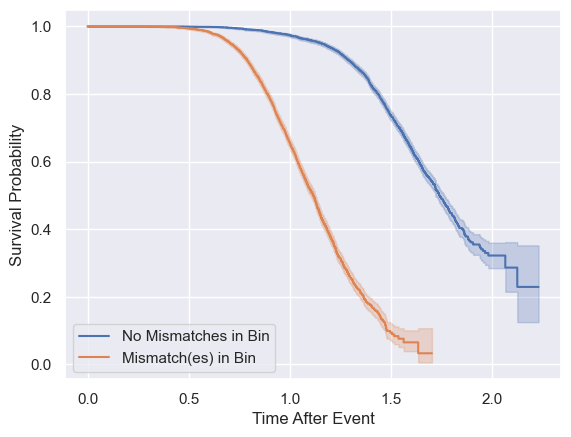

,Bin #,Score,Bins
0,Bin 1,4267.559086,"[P_4, P_1, P_7, P_10]"
1,Bin 2,3878.263791,"[P_8, P_2, P_1]"
2,Bin 3,3788.274513,"[P_8, P_3, P_1]"
3,Bin 4,3781.792314,"[P_2, P_6, P_7]"
4,Bin 5,3759.541884,"[P_3, P_1, P_4]"
5,Bin 6,3713.540286,"[P_3, P_2, P_8]"
6,Bin 7,3713.080450,"[P_1, P_2, P_3]"
7,Bin 8,3486.820609,"[P_4, P_7, P_10]"
8,Bin 9,2923.098066,"[P_8, P_1]"
9,Bin 10,2857.107941,"[P_2, P_5]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:13.505968
Top Bin of Features:
['P_9', 'P_10', 'P_8', 'P_7']
---
Number of Instances with No Mismatches in Bin:
5385
Number of Instances with Mismatch(es) in Bin:
4615
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4383.46 <0.005       inf

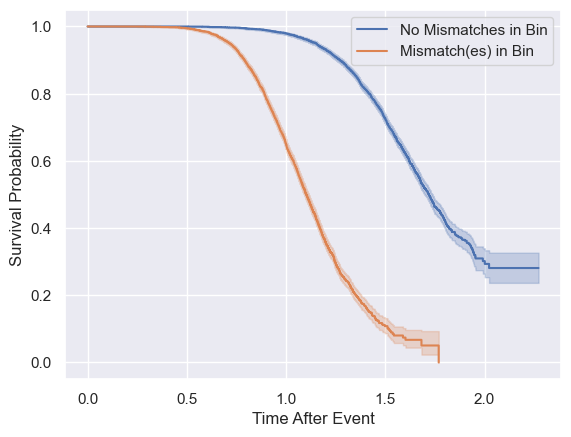

,Bin #,Score,Bins
0,Bin 1,4383.456697,"[P_9, P_10, P_8, P_7]"
1,Bin 2,4342.184336,"[P_9, P_4, P_3, P_10]"
2,Bin 3,3819.121227,"[P_8, P_10, P_2]"
3,Bin 4,3683.747364,"[P_5, P_4, P_1]"
4,Bin 5,3666.381543,"[P_9, P_4, P_3]"
5,Bin 6,2848.139586,"[P_9, P_8]"
6,Bin 7,2826.207358,"[P_6, P_9]"
7,Bin 8,2822.273699,"[P_4, P_9]"
8,Bin 9,2815.565229,"[P_8, P_6]"
9,Bin 10,2810.711910,"[P_5, P_9]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:01:06.624698
Top Bin of Features:
['P_5', 'P_6', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5812
Number of Instances with Mismatch(es) in Bin:
4188
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3794.67 <0.005       inf

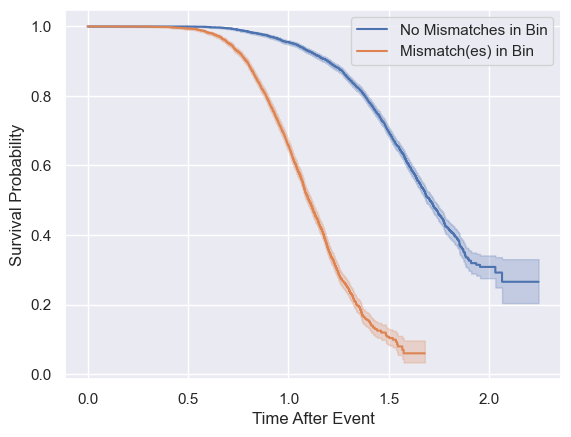

,Bin #,Score,Bins
0,Bin 1,3794.672147,"[P_5, P_6, P_8]"
1,Bin 2,3773.762690,"[P_10, P_2, P_4]"
2,Bin 3,3682.506887,"[P_10, P_6, P_2]"
3,Bin 4,3576.657893,"[P_10, P_6, P_1]"
4,Bin 5,2952.666547,"[P_5, P_8]"
5,Bin 6,2857.061178,"[P_6, P_8]"
6,Bin 7,2785.169366,"[P_5, P_7]"
7,Bin 8,2723.839504,"[P_5, P_10]"
8,Bin 9,2711.891093,"[P_5, P_6]"
9,Bin 10,1573.004685,[P_8]


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:00:23.363859
Top Bin of Features:
['P_8', 'P_10']
---
Number of Instances with No Mismatches in Bin:
6629
Number of Instances with Mismatch(es) in Bin:
3371
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2664.33 <0.005       inf

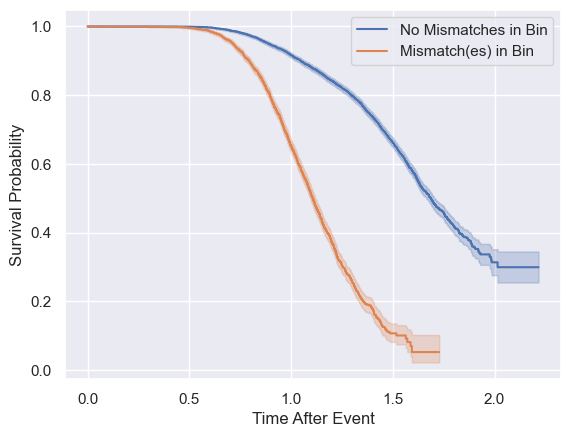

,Bin #,Score,Bins
0,Bin 1,2664.333363,"[P_8, P_10]"
1,Bin 2,1428.243372,[P_8]
2,Bin 3,155.965900,"[P_8, R_91]"
3,Bin 4,146.487891,"[R_212, P_8]"
4,Bin 48,143.047911,"[R_109, P_6]"
5,Bin 5,142.157843,"[R_159, P_10]"
6,Bin 6,133.413316,"[R_223, P_8]"
7,Bin 7,127.259453,"[P_8, R_232]"
8,Bin 8,123.370209,"[P_8, R_29]"
9,Bin 9,122.477422,"[P_8, R_189]"


mm_frequency_range = (0.4, 0.5) noise_frequency = 0 censoring_frequency = 0.5


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:00:10.104994
Top Bin of Features:
['R_178', 'R_155', 'R_379', 'R_177', 'R_111', 'R_231', 'R_90', 'R_42', 'R_9', 'R_169', 'R_133', 'R_227', 'R_23', 'R_81']
---
Number of Instances with No Mismatches in Bin:
2
Number of Instances with Mismatch(es) in Bin:
9998
---
p-value from Log Rank Test:
0.2867309685825882


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.13 0.29      1.80

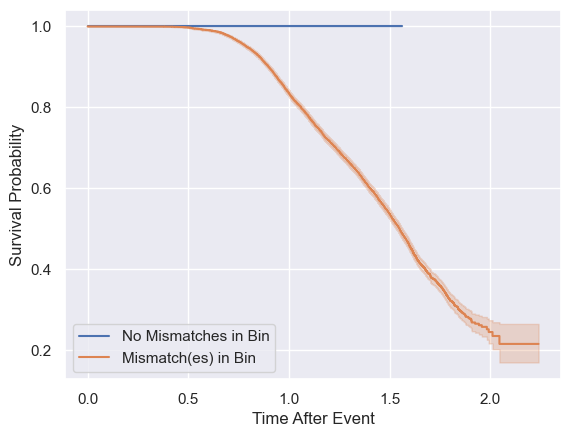

,Bin #,Score,Bins
0,Bin 1,0,"[R_178, R_155, R_379, R_177, R_111, R_231, R_9..."
1,Bin 2,0,"[R_158, R_341, R_164, R_389, R_102, R_1, R_200..."
2,Bin 3,0,"[R_20, R_34, R_362, R_156, P_9, R_88, R_238, R..."
3,Bin 4,0,"[R_247, R_377, R_28, R_313, R_107, R_65, R_223..."
4,Bin 5,0,"[R_208, R_12, R_324, P_3, R_225, R_118, R_244,..."
5,Bin 6,0,"[R_275, R_153, R_234, R_108, R_116, R_331, R_2..."
6,Bin 7,0,"[R_221, R_40, R_29, R_149, R_114, R_386, R_318..."
7,Bin 8,0,"[R_83, R_109, R_306, R_341, R_176, R_157, R_30..."
8,Bin 9,0,"[R_144, R_73, R_8, R_4, R_10, R_349, R_363]"
9,Bin 10,0,"[R_224, R_386, R_381, R_123, R_57, R_219, R_58..."


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/2835751513.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(tdf)


In [36]:
df1 = pd.DataFrame()
for i in [20, 50, 60, 100, 150, 200, 300, 400]:
    try:
        tdf = function(number_of_features=i)
        tdf = tdf.drop(['Bin #'], axis=1).head(10)
        tdf['Num_Features'] = i
        df1 = df1.append(tdf)
    except:
        print("Failed at ", i)

In [37]:
tdf

,Score,Bins,Num_Features
0,0,"[R_178, R_155, R_379, R_177, R_111, R_231, R_9...",400
1,0,"[R_158, R_341, R_164, R_389, R_102, R_1, R_200...",400
2,0,"[R_20, R_34, R_362, R_156, P_9, R_88, R_238, R...",400
3,0,"[R_247, R_377, R_28, R_313, R_107, R_65, R_223...",400
4,0,"[R_208, R_12, R_324, P_3, R_225, R_118, R_244,...",400
5,0,"[R_275, R_153, R_234, R_108, R_116, R_331, R_2...",400
6,0,"[R_221, R_40, R_29, R_149, R_114, R_386, R_318...",400
7,0,"[R_83, R_109, R_306, R_341, R_176, R_157, R_30...",400
8,0,"[R_144, R_73, R_8, R_4, R_10, R_349, R_363]",400
9,0,"[R_224, R_386, R_381, R_123, R_57, R_219, R_58...",400


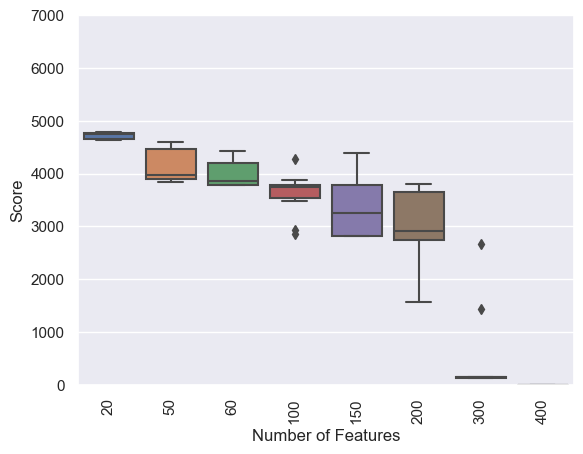

In [38]:
sns.boxplot(y=df1['Score'], x=df1['Num_Features'])
plt.xticks(rotation=90)
plt.xlabel('Number of Features')
plt.ylim(bottom=0, top=7000)
plt.show()

Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:02:14.421022
Top Bin of Features:
['P_4', 'P_6', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5018
Number of Instances with Mismatch(es) in Bin:
4982
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2539.94 <0.005       inf

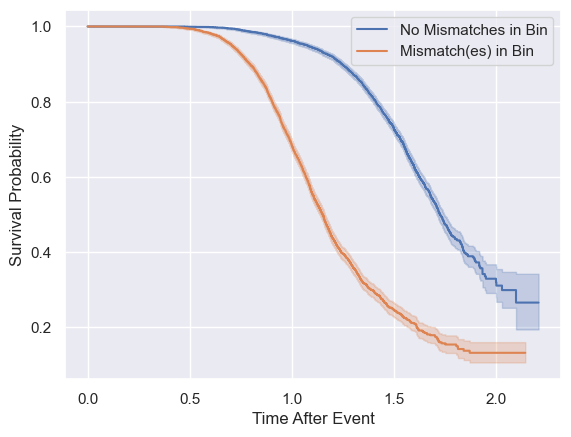

,Bin #,Score,Bins
0,Bin 1,2539.939176,"[P_4, P_6, P_10]"
1,Bin 2,2537.238572,"[P_5, P_7, P_6, P_10]"
2,Bin 3,2537.238572,"[P_7, P_6, P_4, P_10]"
3,Bin 4,2536.515749,"[P_10, P_6, P_7]"
4,Bin 5,2532.304227,"[P_6, P_1, P_10]"
5,Bin 6,2527.118014,"[P_6, P_4, P_8]"
6,Bin 7,2526.303815,"[P_7, P_6, P_1]"
7,Bin 8,2525.151913,"[P_4, P_5, P_7]"
8,Bin 9,2521.982141,"[P_7, P_5, P_6]"
9,Bin 10,2518.188420,"[P_7, P_6, P_3]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:04:36.306634
Top Bin of Features:
['P_3', 'P_1', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5023
Number of Instances with Mismatch(es) in Bin:
4977
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2565.91 <0.005       inf

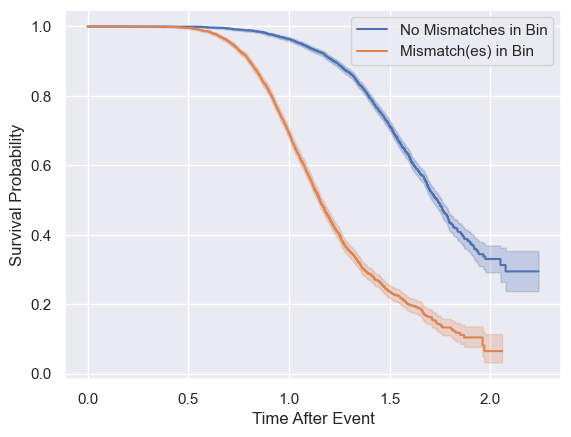

,Bin #,Score,Bins
0,Bin 1,2565.911632,"[P_3, P_1, P_9]"
1,Bin 2,2558.558120,"[P_8, P_5, P_9, P_4]"
2,Bin 3,2556.462037,"[P_7, P_2, P_8]"
3,Bin 4,2555.336376,"[P_4, P_3, P_2]"
4,Bin 5,2552.499422,"[P_2, P_3, P_8]"
5,Bin 6,2550.680601,"[P_5, P_9, P_3]"
6,Bin 7,2550.381456,"[P_3, P_8, P_1]"
7,Bin 8,2549.976082,"[P_2, P_6, P_3]"
8,Bin 9,2548.035604,"[P_10, P_6, P_9]"
9,Bin 10,2546.994886,"[P_2, P_4, P_1]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:06:32.520912
Top Bin of Features:
['P_5', 'P_2', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5017
Number of Instances with Mismatch(es) in Bin:
4983
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2395.23 <0.005       inf

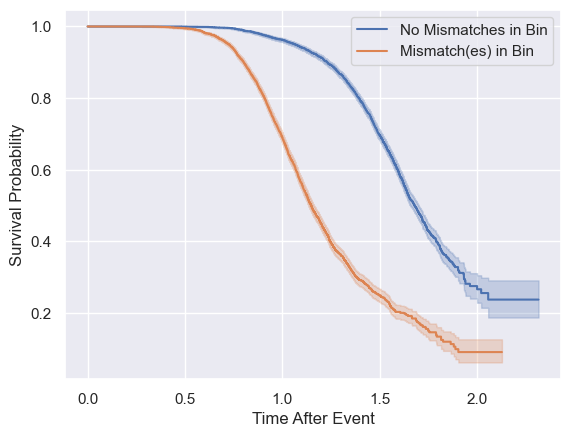

,Bin #,Score,Bins
0,Bin 273,2395.231181,"[P_5, P_2, P_10]"
1,Bin 1,2382.770078,"[P_7, P_4, P_10]"
2,Bin 2,2381.876386,"[P_3, P_7, P_10]"
3,Bin 3,2381.875295,"[P_10, P_5, P_9]"
4,Bin 4,2377.965563,"[P_7, P_6, P_3]"
5,Bin 5,2374.352930,"[P_1, P_3, P_6]"
6,Bin 6,2373.681714,"[P_5, P_10, P_4]"
7,Bin 7,2372.477443,"[P_3, P_10, P_5]"
8,Bin 8,2370.198875,"[P_3, P_7, P_5]"
9,Bin 9,2370.121872,"[P_7, P_3, P_9]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:07:51.682814
Top Bin of Features:
['P_8', 'P_9', 'P_1']
---
Number of Instances with No Mismatches in Bin:
5016
Number of Instances with Mismatch(es) in Bin:
4984
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2365.28 <0.005       inf

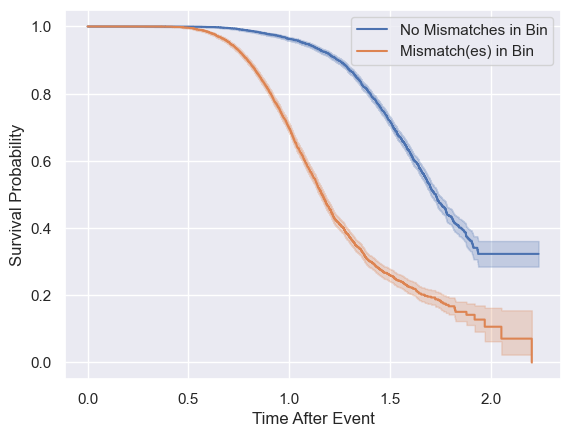

,Bin #,Score,Bins
0,Bin 1,2365.280444,"[P_8, P_9, P_1]"
1,Bin 2,2361.495538,"[P_1, P_9, P_3]"
2,Bin 3,2361.493641,"[P_3, P_4, P_6]"
3,Bin 4,2359.072713,"[P_6, P_9, P_10]"
4,Bin 5,2358.673199,"[P_9, P_10, P_1]"
5,Bin 6,2355.227017,"[P_3, P_5, P_1]"
6,Bin 7,2350.472534,"[P_3, P_9, P_8]"
7,Bin 8,2349.183350,"[P_3, P_9, P_7]"
8,Bin 9,2348.944604,"[P_4, P_6, P_7]"
9,Bin 10,2348.350134,"[P_6, P_9, P_4]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:09:29.327967
Top Bin of Features:
['P_2', 'P_8', 'P_7']
---
Number of Instances with No Mismatches in Bin:
5021
Number of Instances with Mismatch(es) in Bin:
4979
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2595.31 <0.005       inf

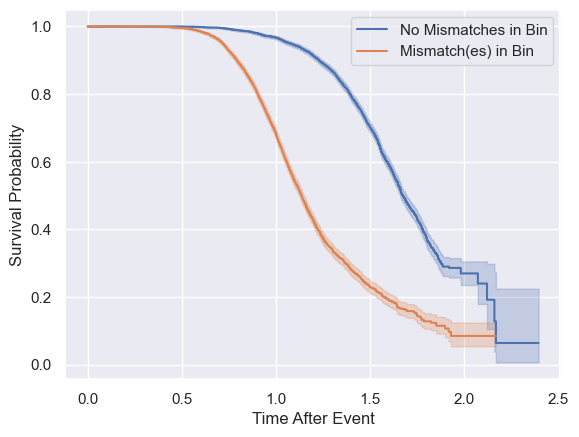

,Bin #,Score,Bins
0,Bin 1,2595.313727,"[P_2, P_8, P_7]"
1,Bin 2,2592.742940,"[P_1, P_4, P_5]"
2,Bin 3,2590.988933,"[P_4, P_10, P_9]"
3,Bin 4,2590.585748,"[P_2, P_4, P_3]"
4,Bin 5,2588.544269,"[P_9, P_2, P_5, P_1]"
5,Bin 6,2588.544269,"[P_8, P_1, P_9, P_7]"
6,Bin 7,2588.544269,"[P_1, P_7, P_5, P_4]"
7,Bin 8,2588.544269,"[P_8, P_2, P_9, P_7]"
8,Bin 9,2588.544269,"[P_5, P_8, P_2, P_7]"
9,Bin 10,2588.544269,"[P_4, P_8, P_1, P_7]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:13:00.418407
Top Bin of Features:
['P_1', 'P_7', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5016
Number of Instances with Mismatch(es) in Bin:
4984
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2552.46 <0.005       inf

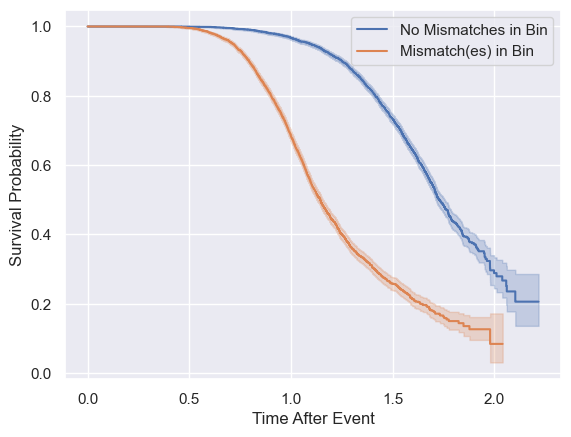

,Bin #,Score,Bins
0,Bin 1,2552.458901,"[P_1, P_7, P_5]"
1,Bin 2,2541.446840,"[P_8, P_9, P_1]"
2,Bin 3,2540.953723,"[P_8, P_2, P_5]"
3,Bin 4,2540.891591,"[P_3, P_5, P_10]"
4,Bin 5,2539.306888,"[P_1, P_9, P_4]"
5,Bin 6,2537.450446,"[P_2, P_10, P_9]"
6,Bin 7,2536.922633,"[P_7, P_8, P_10]"
7,Bin 8,2534.818860,"[P_1, P_8, P_10]"
8,Bin 9,2532.982657,"[P_8, P_5, P_7]"
9,Bin 10,2532.905975,"[P_7, P_1, P_4]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:13:43.671864
Top Bin of Features:
['P_10', 'P_2', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5025
Number of Instances with Mismatch(es) in Bin:
4975
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2539.98 <0.005       inf

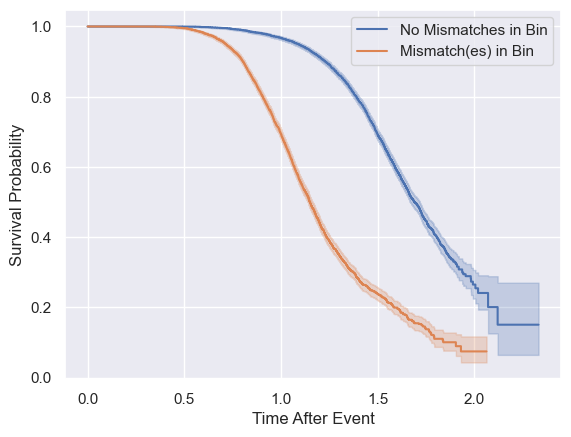

,Bin #,Score,Bins
0,Bin 1,2539.983668,"[P_10, P_2, P_8]"
1,Bin 2,2536.967869,"[P_1, P_4, P_9]"
2,Bin 3,2536.679195,"[P_2, P_7, P_5]"
3,Bin 4,2536.437571,"[P_2, P_5, P_6, P_8]"
4,Bin 5,2536.437571,"[P_2, P_9, P_7, P_5]"
5,Bin 6,2536.437571,"[P_9, P_6, P_5, P_7]"
6,Bin 7,2536.437571,"[P_7, P_5, P_6, P_8]"
7,Bin 8,2536.437571,"[P_9, P_6, P_7, P_2]"
8,Bin 9,2536.437571,"[P_2, P_6, P_9, P_8]"
9,Bin 10,2536.437571,"[P_2, P_9, P_5, P_10]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:16:53.109531
Top Bin of Features:
['P_4', 'P_8', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5021
Number of Instances with Mismatch(es) in Bin:
4979
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2309.26 <0.005       inf

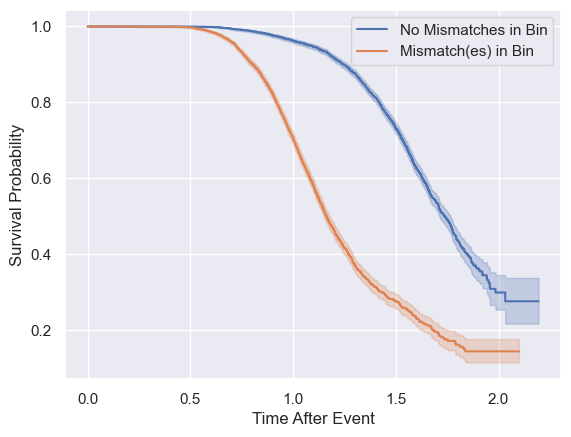

,Bin #,Score,Bins
0,Bin 1,2309.261186,"[P_4, P_8, P_5]"
1,Bin 2,2303.116558,"[P_6, P_5, P_10]"
2,Bin 3,2302.280966,"[P_10, P_7, P_2]"
3,Bin 4,2300.211344,"[P_1, P_4, P_3]"
4,Bin 5,2300.209660,"[P_6, P_2, P_7]"
5,Bin 6,2298.177508,"[P_5, P_1, P_4]"
6,Bin 7,2296.870314,"[P_9, P_6, P_3]"
7,Bin 8,2296.520423,"[P_4, P_3, P_6]"
8,Bin 9,2295.522530,"[P_6, P_5, P_3]"
9,Bin 10,2294.525314,"[P_4, P_7, P_2]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:20:21.123246
Top Bin of Features:
['P_7', 'P_4', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5020
Number of Instances with Mismatch(es) in Bin:
4980
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2488.05 <0.005       inf

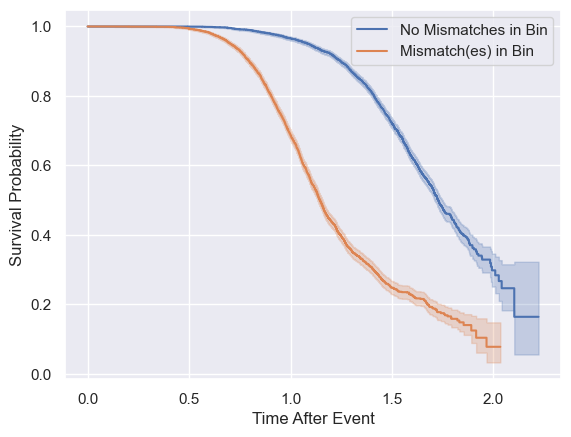

,Bin #,Score,Bins
0,Bin 1,2488.050901,"[P_7, P_4, P_5]"
1,Bin 2,2486.629993,"[P_7, P_1, P_10]"
2,Bin 3,2483.247658,"[P_2, P_10, P_5]"
3,Bin 806,2481.420505,"[P_10, P_8, P_5]"
4,Bin 755,2479.319387,"[P_8, P_2, P_1]"
5,Bin 4,2476.440907,"[P_7, P_5, P_2]"
6,Bin 5,2476.385687,"[P_10, P_6, P_9]"
7,Bin 6,2476.005531,"[P_1, P_10, P_6]"
8,Bin 7,2474.487403,"[P_2, P_5, P_3]"
9,Bin 8,2473.884777,"[P_7, P_5, P_10]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:23:50.243129
Top Bin of Features:
['P_9', 'P_2', 'P_10']
---
Number of Instances with No Mismatches in Bin:
5016
Number of Instances with Mismatch(es) in Bin:
4984
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2485.57 <0.005       inf

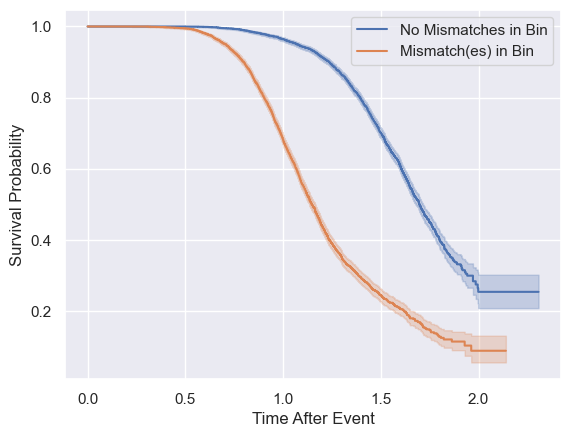

,Bin #,Score,Bins
0,Bin 1,2485.570327,"[P_9, P_2, P_10]"
1,Bin 2,2483.441563,"[P_6, P_1, P_9]"
2,Bin 3,2483.087029,"[P_5, P_7, P_9]"
3,Bin 4,2483.080056,"[P_4, P_7, P_9]"
4,Bin 5,2482.217768,"[P_7, P_1, P_6]"
5,Bin 6,2482.117937,"[P_8, P_2, P_5]"
6,Bin 7,2480.038859,"[P_8, P_3, P_1]"
7,Bin 8,2479.866656,"[P_5, P_6, P_2, P_4]"
8,Bin 9,2479.866656,"[P_1, P_6, P_2, P_3]"
9,Bin 908,2479.866656,"[P_6, P_2, P_1, P_7]"


/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_63830/3860664899.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(tdf)


In [39]:
df2 = pd.DataFrame()
for i in range(100, 1001, 100):
    big_training_data = create_data_simulation_bin(
                                number_of_instances=10000, number_of_features=i, number_of_features_in_bin=10,
                                no_fail_proportion=0.5, mm_frequency_range=(0.7, 0.9) , noise_frequency=0.1,
                                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2), 
                                censoring_frequency=0.5)
    print("Running Simulation")
    start_time = datetime.datetime.now()
    big_training_data = big_training_data.drop('TrueRiskGroup', axis=1)
    bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, \
                MAF_0_features = SurvivalRARE(given_starting_point=False, 
                                              amino_acid_start_point=False, 
                                              amino_acid_bins_start_point=False, 
                                              iterations=100, original_feature_matrix=big_training_data, 
                                              label_name="Censoring", duration_name="Duration", 
                                              set_number_of_bins=i, 
                                              min_features_per_group=2, 
                                              max_number_of_groups_with_feature=2, 
                                              informative_cutoff=0.2,
                                              crossover_probability=0.8, 
                                              mutation_probability=0.4, 
                                              elitism_parameter=0.8)

    run_time = datetime.datetime.now() - start_time
    print("Runtime", run_time)
    Top_Bin_Summary(big_training_data, 'Censoring', 'Duration', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)
    #      Top_Bin_Summary_Test(testing_data, 'Censoring', 'Duration', MAF_0_features, amino_acid_bins, amino_acid_bin_scores)
    sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    Bin = amino_acid_bins[sorted_bin_list[0]]
    #     print(Bin)
# return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features
    amino_acid_bin_scores_sorted = sorted(amino_acid_bin_scores.items(), 
                                               key=lambda x:x[1], reverse=True)
    amino_acid_bins_sorted = sorted(amino_acid_bins.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10))
    tdf = tdf3.drop(['Bin #'], axis=1).head(10)
    tdf['Num_Features'] = i
    df2 = df2.append(tdf)

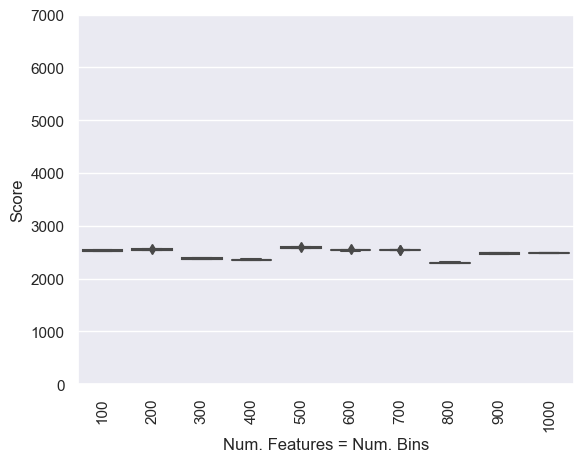

In [40]:
sns.boxplot(y=df2['Score'], x=df2['Num_Features'])
plt.xticks(rotation=90)
plt.xlabel('Num. Features = Num. Bins')
plt.ylim(bottom=0, top=7000)
plt.show()

In [41]:
big_training_data = create_data_simulation_bin(
                                number_of_instances=10000, number_of_features=5000, number_of_features_in_bin=10,
                                no_fail_proportion=0.5, mm_frequency_range=(0.7, 0.9) , noise_frequency=0.1,
                                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2), 
                                censoring_frequency=0.5)

Running Simulation


  0%|          | 0/100 [00:00<?, ?it/s]

Runtime 0:23:39.085094
Top Bin of Features:
['P_9', 'P_5', 'P_7']
---
Number of Instances with No Mismatches in Bin:
5019
Number of Instances with Mismatch(es) in Bin:
4981
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2591.17 <0.005       inf

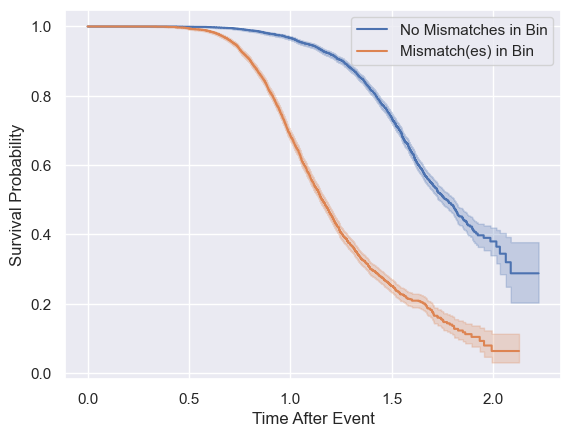

In [42]:
print("Running Simulation")
start_time = datetime.datetime.now()
big_training_data = big_training_data.drop('TrueRiskGroup', axis=1)
bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, \
            MAF_0_features = SurvivalRARE(given_starting_point=False, 
                                          amino_acid_start_point=False, 
                                          amino_acid_bins_start_point=False, 
                                          iterations=100, original_feature_matrix=big_training_data, 
                                          label_name="Censoring", duration_name="Duration", 
                                          set_number_of_bins=5000, 
                                          min_features_per_group=2, 
                                          max_number_of_groups_with_feature=2, 
                                          informative_cutoff=0.2,
                                          crossover_probability=0.8, 
                                          mutation_probability=0.4, 
                                          elitism_parameter=0.8)

run_time = datetime.datetime.now() - start_time
print("Runtime", run_time)
Top_Bin_Summary(training_data, 'Censoring', 'Duration', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)
#      Top_Bin_Summary_Test(testing_data, 'Censoring', 'Duration', MAF_0_features, amino_acid_bins, amino_acid_bin_scores)
sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
sorted_bin_list = list(sorted_bin_scores.keys())
sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
Bin = amino_acid_bins[sorted_bin_list[0]]
#     print(Bin)
# return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features